# **Advanced Lane Lines Finding Using Python and OpenCV**
---

[intro](https://i.imgur.com/ablKSmI.jpg)


**In this project, I have detected lane lines on the road in several circumstances, straight lane lines, curvy, and in different lighting conditions using _Python_ and _OpenCV_.**

**Firstly, I have worked on camera calibration for undistorting the images**

**Then, I have developed a computer vision pipeline that processes a group of test images then applied this pipeline to a test video stream.**

## Pipeline Architecture:
---

0. Calibrate camera using calibration images. This step is done only once, i.e., not repeated with the processing of each image
1. Undistort the image under processing
2. Apply gradient and color thresholdss (Sobelx, S channel, and L channel thresholds)
3. Cut-out any edges that are out of the lane lines region (**region of interest**)
4. Warp the image perspective to be in top-down (bird's eye) view
5. Search on lane lines in the image
  * Using the sliding window technique
  * If the previous lane lines detections are in reasonable area, search on lane lines based on previous frame
6. Calculae the lane curvature and vehicle distance from the lane center.
  In this step we are also doing:
  * Drawing the lane line on blank image
  * Warping the blank back to original image space
  * Weighting the original image with the lane lines image

## Environment:
---
* Ubuntu 16.04 LTS
* Python 3.6.4
* OpenCV 3.1.0
* Anaconda 4.4.10

## Import Packages

In [1]:
#importing some useful packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from moviepy.editor import VideoFileClip
%matplotlib qt

### 1. Calibrate camera using calibration images
---

A distortion is actually changing what the shape and size of these objects appear to be. So, we need to undistort images to reflect our real world surrondings.

To do so, a primary step is to measure that distortion, i.e., calibrate for distortion.

We can take pictures of known shapres then we will be able to detect and correct any distortion errors

We will use a chessboard as it s great for calibration because of its regular high contrast pattern, and aslo we know what undistorted flat chessboard looks like.

So, if we use our camera to take multiple pictures of a chessboard against a flat surface then weill be able to detect any distortion by looking at the difference between the apparent size and shape of the squares in these images, and the shape and size of the actual image.

Then we will use this information to calibrate our camera.

At this step we will be able to create a transform that maps these distorted points to undistorted points and finally we can undistort any image.

**In the following function we are doing the following for camera calibration:**
  * We map the coordinates of the corners in the 2-D image, which we will call `imgpoints` to the 3-D coordinates of the real chessboard corners which we will call `objpoints`. We will setup them as two empty arrays to hold these points
  * The object points will be the same as the known object coordinates of the chessboard corners for the 9 x 6 board. These points will be the 3-D coordinates x, y, and z from the top-left corner (0, 0, 0) to the botton right (8, 5, 0)
  * The z-coordinate will be zero for every object point. So, we will prepare these object points firstly be creating 9 x 6 point in an array each with 3 column for the x, y, and z coordinate. We will initialize all of these as zeros using numpy's `zeros` function
  * The z-coordinate will stay zero, so we will keept it as it is but for the first two columnsx and y we will use numpy's `mgrid` functionto generate the coordinates that we want.
  * `mgrid` returns the coordinates values for a given grid size and we will shape these coordinates back into two columns, one for x and other for y.
  * To create the image points, OpenCV gices an easy way to detect the chessboard corners with a function called `findChessboardCorners` that returns the corneers found in grayscale image. So, we will convert the image into grayscale and pass it to the `findChessboardCorners` function
  *  These `imgpoints` and `objpoints` are used to calibrate the camera using a function called `calibrateCamera`

In [2]:
%matplotlib qt
def get_objectPoints_imgPoints_corners(calibration_images, nx, ny):
    """
    Descrition:
        This function helps calibrate the camera by getting the objects points and image points 
        for chessboard calibration images
    Paramteres:
        calibration_images: List of chessboard calibration images
        nx: number of inside corners in x
        ny: number of inside corners in y
    Output:
        objpoints: Object points
        imgpoints: Image points
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(calibration_images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            #Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            write_name = 'test_images_output/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
            cv2.imshow('img', img)
            cv2.waitKey(500)
        else:
            print("corner is not detected")

    cv2.destroyAllWindows()
    

    
    return objpoints, imgpoints

print("Done")

Done


This function is used to calibrate the camera. It takes the `objpoints` and `imgpoints` and returns the distortion coefficients `dist` and the camera matrix that we need to tranform 3-D object points to 2-D image points `mtx`

In [3]:
def calibrate_camera(objpoints, imgpoints, img_size):
    """
    Descrition:
        This function calibrates the camera
    Paramteres:
        objpoints: Object points
        imgpoints: Image points
        img_size : size of the image
    Output:
        mtx: the camera matrix that we need to tranform 3-D object points to 2-D image points
        dist: the distortion coefficients
    """
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    return mtx, dist

print("Done")

Done


### 2. Undistort the image under processing
---

This function is used to undistort the image using the OpenCV function `cv2.undistort`

In [4]:
def undistort(img, mtx, dist, test_images_mode=False):
    """
    Descrition:
        This function undistort the image under processing
    Paramteres:
        img: Distoted image to be undistorted
        mtx: the camera matrix that we need to tranform 3-D object points to 2-D image points
        dist: the distortion coefficients
    Output:
        undist: undistorted image
    """
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #cv2.imwrite('output_images/test_undist.jpg',undist)
    
    if test_images_mode == True:
        if not hasattr(undistort, "counter"):
            undistort.counter = 0  # it doesn't exist yet, so initialize it
        undistort.counter += 1

        write_name = 'test_images_output/00_undistorted_image_'+str(undistort.counter)+'.jpg'
        cv2.imwrite(write_name, undist)
    
    
    return undist

print("Done")

Done


### 3. Apply gradient and color thresholdss (Sobelx, S channel, and L channel thresholds)
---

Here we need to detect the edges that are tending in some sorts to be vertical. This is achieved taking the image derivative in x-direction, i.e., the gradient in x-direction. This is called sobelx threshold.

But, the fact is RGB color spaces are not sufficient enough specially in different lighting conditions (like shadows) and some color (like yellow) can easily disappear when applying RGB thesholding.

So, depending on other color spaces may be useful for getting important information of an image to find the lane lines. 

One of othe color spaces is HLS (Hue, Lightness, and Saturation).

We can find using this color space that the S component of a channel detects the lane lines pretty well. This components stays fairly consistent under shadow or excessive brightness

Also, the L component isolates the lightness of each component which varies the most under different lighting conditions

So, if we use these channels, we should be able to detect different colors of the lane lines more reliabely that in R, G, and B color space only.

In the following function, we have used the sobelx, S channel, and L channel threshold for detecting the lane lines in different cirmustances.

In [5]:
def sobelx_s_l_channels_thresholds(img, s_thresh=(170, 255), l_threshold=(150,200) , sx_thresh=(20, 100), test_images_mode=False):
    """
    Descrition:
        Applies the sobelx, s channel, and l channel threshold to an image
    Paramteres:
        img: Undistorted image to apply the thresholds to
        s_thresh: S channel threshold range
        l_threshold: L channel threshold range
        sx_thresh: Sobel x threshold range
    Output:
        combined_binary: Binary image that has edges detected
    """
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Threshold color channel (s channel)
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
     # Threshold color channel (l channel)
    l_binary = np.zeros_like(l_channel)
    l_binary[(s_channel >= l_threshold[0]) & (s_channel <= l_threshold[1])] = 1

    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    

    # Stack each channel
    color_binary = np.dstack(( sxbinary, s_binary, l_binary)) 
    
    combined_binary = np.zeros_like(sxbinary)

    #combined_binary[(s_binary == 1) |  (sxbinary == 1) | (l_binary == 1)] = 1
    combined_binary[(s_binary == 1) |  (sxbinary == 1)] = 1

    combined_binary = np.asarray(combined_binary)
    
    if test_images_mode == True:
        if not hasattr(sobelx_s_l_channels_thresholds, "counter"):
            sobelx_s_l_channels_thresholds.counter = 0  # it doesn't exist yet, so initialize it
        sobelx_s_l_channels_thresholds.counter += 1
        
        write_name = 'test_images_output/01_color_thresholds_'+str(sobelx_s_l_channels_thresholds.counter)+'.jpg'
        (thresh, im_bw) = cv2.threshold(combined_binary, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        cv2.imwrite(write_name, im_bw)
            
    return combined_binary

print("Done")

Done


### 4. Cut-out any edges that are out of the lane lines region **(region of interest)**
---

This function is used to have a better output for the histogram when applying the sliding window search of the next function. The regoin of interest function cuts out any other edges that may be detected out the lane lines region defined by the polygon vertices:
```
bottom_left  = (140,image_shape[0])
up_left      = (550, 400)
up_right    = (780, 400)
bottom_right    = (1250,image_shape[0])
```

where `image_shape[0]` is the y-coordinate of the image under processing.

In [6]:
def region_of_interest(image, image_shape, test_images_mode=False):
    """
    Descrition:
        Applies an image mask. Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
    Paramteres:
        image: The image to cut-out any other edges out if region of interest
        image_shape: shape of image under processing
    Output:
        An image that has the edges in the defined polygon and black everywhere else
    """
    
    #image_shape  = image.shape
    # The following points are the vertices points of the polygon
    bottom_left  = (140,image_shape[0])
    up_left      = (550, 400)
    up_right    = (780, 400)
    bottom_right    = (1250,image_shape[0])
    vertices     = np.array([[bottom_left, up_left, up_right , bottom_right]], dtype=np.int32)
    
    #defining a blank mask to start with
    mask = np.zeros_like(image)   
    #mask = np.copy(image)*0 
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image_shape) > 2:
        channel_count = image_shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    
    #cv2.polylines(masked_image,[vertices],True,(255,255,255))
    
    if test_images_mode == True:
        if not hasattr(region_of_interest, "counter"):
            region_of_interest.counter = 0  # it doesn't exist yet, so initialize it
        region_of_interest.counter += 1

        write_name = 'test_images_output/02_roi_image_'+str(region_of_interest.counter)+'.jpg'
        (thresh, im_bw) = cv2.threshold(masked_image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        cv2.imwrite(write_name, im_bw)
        
    return masked_image

print("Done")

Done


### 5. Warp the image perspective to be in top-down (bird's eye) view
---

In an image, perspective is the phenomenon where objects appears smaller the farther away it is from a viewpoint like a camera, and parallel lines appear to converge to a point.

Here, we change our images to bird's eye view scene. This is really useful because some tasks like finding the curvature of a lane are easier to perform on a bird's eye view of an image. Also, it is useful to locate car's locatio directly with a map, since maps display roads from a top-down view.

To create a perspective transfrom:
  * We firstly select four points that define a the lane lines in our image which is trapezoidal shape. `src`
  * Then we select where we want there four points to appear in the warped image. These points basically represent a rectangle forming a line in a bird's eye view. `dst`
  * Then we use OpenCV function `cv2.getPerspectiveTransform` to calculate the transform matrix that maps the original image to the warped image.
  * We can get the inverse perspective transform to unwarp by just switching the `src` and `dst`
  * To apply the perspective transform matrix to the original image, we use the OpenCV function `cv2.warpPerspective` which returns the warped image.
  
> Note: when the input to this function is the chessboard image, we use automatice detection to `src` and `dst` based on the chessboard corners.

In [7]:
def warp_image_perspective(undist, nx=9, ny=6, test_images_mode=False):
    """
    Descrition:
        Applies perspective transfrom to get the image in bird's eye view
    Paramteres:
        undist: The undistorted image
        nx: number of inside corners in x
        ny: number of inside corners in y
    Output:
        warped_image: Image in bird's eye (top-down) view 
        M: Tranformation matrix from original image to bird's eye view 
        Minv: Inverse matrix from bird's eye view to original view
    """
    image_shape = undist.shape
    img_size = (undist.shape[1] , undist.shape[0])
    ret, corners = cv2.findChessboardCorners(undist, (nx, ny), None)
        
    offset = 50
    
    if ret == True:
        
        top_left = corners[0]
        top_right = corners[nx-1]
        bottom_right = corners[-1]
        bottom_left = corners[-nx]

        src = np.float32([top_left,
                          top_right,
                          bottom_right,
                          bottom_left])
        
        dst = np.float32([[offset, offset],
                  [img_size[0]-offset, offset],
                  [img_size[0]-offset, img_size[1]-offset],
                  [offset, img_size[1]-offset]])
    
    else:
        # The following points are the vertices points of the polygon
        src_bottom_left  = (200,image_shape[0]-offset)
        src_top_left      = (580, 450)
        src_top_right     = (700, 450)
        src_bottom_right = (1100,image_shape[0]-offset)
        
#         vertices     = np.array([[bottom_left, top_left, top_right , bottom_right]], dtype=np.int32)

        src = np.float32([src_top_left,
                          src_top_right,
                          src_bottom_right,
                          src_bottom_left])

        #cv2.polylines(undist,[vertices],True,(255,255,255), thickness=5)
        
        #The following points are the vertices points of the rectangle
        dst_bottom_left  = (300,image_shape[0])
        dst_top_left     = (300, 0)
        dst_top_right    = (950, 0)
        dst_bottom_right = (950,image_shape[0])

        dst = np.float32([dst_top_left,
                          dst_top_right,
                          dst_bottom_right,
                          dst_bottom_left])           
                       
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped_image = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    
    warped_image = np.asarray(warped_image)
    
    if test_images_mode == True:
        if not hasattr(warp_image_perspective, "counter"):
            warp_image_perspective.counter = 0  # it doesn't exist yet, so initialize it
        warp_image_perspective.counter += 1

        write_name = 'test_images_output/03_warped_image_'+str(warp_image_perspective.counter)+'.jpg'
        (thresh, im_bw) = cv2.threshold(warped_image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        cv2.imwrite(write_name, im_bw)
    
    return warped_image, M, Minv

print("Done")

Done


### 6. Search on lane lines in the image
---
#### Using the sliding window technique
#### If the previous lane lines detections are in reasonable area, search on lane lines based on previous frame

After applying calibration, undistorting, thersholding, regoin of interest, and perspective transform to a road image, we now have an image where lane lines standout clearly. However, we still need to decide explicitly which pixels are part of the lines and which belong to the left and which belong to the right line.

#### Using the sliding window technique
---
  * First, we take the histogram to the lower half of the image
  * We can use the values from this histogram as a starting point for where to search for lines
  * From these point, we can use sliding window placed around the line centers to find and follow the lines up to the top of the frame to get left and right x and y pixels of the lane lines
  * After getting these points, we can fit a second-degree polynomial using `np.polyfit(lefty, leftx, 2)` and `np.polyfit(righty, rightx, 2)`
  * Then we plot these lane lines detected

In [8]:
def search_for_lane_lines(warped_roi_image, test_images_mode=False):
    """
    Descrition:
        Searches for lane lines in warped image based on sliding window technique
    Paramteres:
        warped_roi_image: The warped image
    Output:
        out_img: Output image that has the lane lines detected
        leftx: Left lane line pixels x-position
        lefty: Left lane line pixels y-position
        rightx: right lane line pixels x-position
        righty: right lane line pixels y-position 
        left_fit: Coeffecients of the second-degree ploynomial fit for the left lane
        right_fit: Coeffecients of the second-degree ploynomial fit for the right lane
        left_fitx: Left lane x values used for plotting the lane line
        right_fitx: Right lane x values used for plotting the lane line
        ploty: Y values used for plotting the lane line
    """
    histogram = np.sum(warped_roi_image[warped_roi_image.shape[0]//2:,:], axis=0)
    out_img = np.dstack((warped_roi_image, warped_roi_image, warped_roi_image))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_roi_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds  = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_roi_image.shape[0] - (window+1)*window_height
        win_y_high = warped_roi_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_roi_image.shape[0]-1, warped_roi_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    #Save image here
    if test_images_mode == True:
        if not hasattr(search_for_lane_lines, "counter"):
            search_for_lane_lines.counter = 0  # it doesn't exist yet, so initialize it
        search_for_lane_lines.counter += 1
        
        write_name = 'test_images_output/04_lane_lines_image_'+str(search_for_lane_lines.counter)+'.jpg'
        cv2.imwrite(write_name, out_img)
    
    
    return out_img, leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty

print("Done")

Done


#### If the previous lane lines detections are in reasonable area, search on lane lines based on previous frame
---
  * Based on the left and right lane lines detections have drifts to specific values or not, we can depend on plane lines detected from previous frame applying a margin value.
  * After applying this margin to previous lane lines, we can extract the right and left x and y pixels for lane lines.
  * Like the previous function, we can fit a second-degree polynomial using `np.polyfit(lefty, leftx, 2)` and `np.polyfit(righty, rightx, 2)`
  * Then we plot these lane lines detected
  
> I will be commenting and explaining more about the specific values drifts (filtering to re-do the sliding window or depend on previous frame) at the `algorithm_pipline` function

In [9]:
def search_for_lane_lines_based_on_previous_frame(warped_roi_image, left_fit, right_fit):
    """
    Descrition:
        Searches for lane lines in warped image based on previous frame
    Paramteres:
        warped_roi_image: The warped image
        left_fit: Coeffecients of the second-degree ploynomial fit for the left lane from previous frame
        right_fit: Coeffecients of the second-degree ploynomial fit for the right lane from previous frame
    Output:
        result: Output image that has the lane lines detected
        leftx: Left lane line pixels x-position
        lefty: Left lane line pixels y-position
        rightx: right lane line pixels x-position
        righty: right lane line pixels y-position 
        left_fit: Coeffecients of the second-degree ploynomial fit for the left lane
        right_fit: Coeffecients of the second-degree ploynomial fit for the right lane
        left_fitx: Left lane x values used for plotting the lane line
        right_fitx: Right lane x values used for plotting the lane line
        ploty: Y values used for plotting the lane line
    """
    # Assume you now have a new warped binary image 
    # from the next frame of video 
    # It's now much easier to find line pixels!
    nonzero = warped_roi_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 100
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
                                   left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) +
                                                                         left_fit[1]*nonzeroy + left_fit[2] + margin)))
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) +
                                                                           right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    
    
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_roi_image.shape[0]-1, warped_roi_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped_roi_image, warped_roi_image, warped_roi_image))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    
    return result, leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty

print("Done")

Done


### 7. Calculae the lane curvature and vehicle distance from the lane center.
---
This function also containts:
  * Draw the lane line on blank image
  * Warp the blank back to original image space using inverse perspective matrix (inv_perspective_M)
  * Weighting the original image with the lane lines image

This function is used to:
  * determine the lane curvature in real world space (not in pixels space)
  * determine the distace of vehicle position from lane center
  * weight the lane lines on the undistorted image

#### Determine the lane curvature in real world space (not in pixels space)
---
  * To convert from pixels space to meters, the following equations are used for both x and y, 
  `ym_per_pix = 30/720` and `xm_per_pix = 3.7/700`
  * As we have done when searching for lane lines, we fit a second-degree polynomial but for real world values not for pixel values
  * The radius of curvature is define as:
![rad_cur](https://i.imgur.com/fCv3cbS.png)
where we can get `A` and `B` from fitting the second-degree ploynomial.

  * Implementation of the previous equation for the left curvature will look like:  
  `left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])`
  
  
  * Implementation of the previous equation for the right curvature will look like:  
  `right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])`
  
  
  * Estimating the radius of curvature as the mean of the right and left curvatures.

#### Determine the distace of vehicle position from lane center
---
  * For determining the distace from the lane center we need to determine the vehicle position and the lane center
  * For the vehicle position, I will assume it is in the center of the x of the image, assuming that the front camera is mounted in the center of the hood.
  * For the estimated lane center, I get an average value for the max and min left and right x value. Then I get their mean to estimate the lane center.
  * Subtracting the vehicle postion from the estimated lane center, we can get the distance in pixels value
  * Converting this distance from pixels to meters, we get the vehicle's distance from the lance center
  
#### Weight the lane lines on the undistorted image
---
  * At the end, draw lane lines on blank image
  * Warp the blank back to original image space using inverse perspective matrix (inv_perspective_M)
  * Then we weight this image to the undistorted original image.
  * We put the text of radius of curvature and vehicle distance from lane center

In [10]:
def calculate_lane_curvature_and_vehicle_position(undistorted_image, lane_lines_image, leftx, lefty, ploty, rightx, righty,left_fitx, right_fitx, inv_perspective_M, test_images_mode=False):
    """
    Descrition:
        Calculates the lane curvature and vehicle distance from lane center.
    Paramteres:
        undistorted_image: undistorted original image
        lane_lines_image: Image that has lane lines 
        leftx: Left lane line pixels x-position
        lefty: Left lane line pixels y-position
        ploty: Y values used for plotting the lane line
        rightx: right lane line pixels x-position
        righty: right lane line pixels y-position 
        left_fitx: Left lane x values used for plotting the lane line
        right_fitx: Right lane x values used for plotting the lane line
        inv_perspective_M: Inverse transformation matrix from bird's view to original view
    Output:
        result: Output image with lane lines determined, radius of curvature, and vehicle distance from lane center
    """
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image    
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    
        
    # Create an image to draw the lines on
    color_warp = np.zeros_like(lane_lines_image).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (inv_perspective_M)
    newwarp = cv2.warpPerspective(color_warp, inv_perspective_M, (lane_lines_image.shape[1], lane_lines_image.shape[0]))
    
    result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    
    lane_curvature = (left_curverad + right_curverad) / 2
    curve_str = "Lane Curvature " + '{:04.3f}'.format(lane_curvature) + " m" # + " m .. Right Line Curvature " + str(right_curverad)+ " m"
    
    
    if lane_curvature > 2000:
        curve_str = curve_str + " (it seems a straight lane !) "

    veh_center_pos = lane_lines_image.shape[1] / 2
    left_pnt = ( np.max(leftx) + np.min(leftx) ) / 2
    right_pnt = ( np.max(rightx) + np.min(rightx) ) / 2
    lane_center =  ( left_pnt + right_pnt ) / 2
    distance_from_lane_center = (lane_center - veh_center_pos) * xm_per_pix

    pos_str = "Distance from lane center " + '{:04.3f}'.format(distance_from_lane_center) + " m"
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10,100)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    cv2.putText(result,curve_str,
                bottomLeftCornerOfText,
                font,
                fontScale,
                fontColor,
                lineType)
    
    bottomLeftCornerOfText = (10,200)
    cv2.putText(result,pos_str,
                bottomLeftCornerOfText,
                font,
                fontScale,
                fontColor,
                lineType)
    
    #Save image here
    if test_images_mode == True:
        if not hasattr(calculate_lane_curvature_and_vehicle_position, "counter"):
            calculate_lane_curvature_and_vehicle_position.counter = 0  # it doesn't exist yet, so initialize it
        calculate_lane_curvature_and_vehicle_position.counter += 1

        write_name = 'test_images_output/05_curv_vpos_'+str(calculate_lane_curvature_and_vehicle_position.counter)+'.jpg'
        cv2.imwrite(write_name, result)
    
    return result

print("Done")

Done


### This function is sed to save the camera matrix that we need to tranform 3-D object points to 2-D image points and the distortion coefficients into a pickle file for future use.

In [11]:
def save_calibration_results(mtx, dist):
    """
    Descrition:
        Saves the calibration results to a pickle file
    Paramteres:
        mtx: the camera matrix that we need to tranform 3-D object points to 2-D image points
        dist: the distortion coefficients
    """
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )
    
print("Done")

Done


### This function is used to keep the important lane lines feature to be used in next algorithm iteration.

In [12]:
class Lane_Features():
    
    def __init__(self):
        self.leftx = []
        self.lefty = []
        self.rightx = []
        self.righty = []
        self.left_fit = []
        self.right_fit = []
        self.left_fitx = []
        self.right_fitx = []
        self.ploty = []

### In the following code, we are using the calibration images to calibrate the camera using `get_objectPoints_imgPoints_corners` and `calibrate_camera` functions

In [13]:
# Make a list of calibration images
calibration_images = glob.glob('camera_cal/calibration*.jpg')
print(calibration_images)

# Set number of x points and y points in your chessboard calibaration images
nx = 9
ny = 6

# Get the object points, image points, and corners from the calibration images
objpoints, imgpoints = get_objectPoints_imgPoints_corners(calibration_images, nx, ny)

# Calibrate an image
img = cv2.imread('camera_cal/calibration17.jpg')
img_size = (img.shape[1], img.shape[0])
mtx, dist = calibrate_camera(objpoints, imgpoints, img_size)

# Test undistortion on an image
undistorted_cal_image = undistort(img, mtx, dist)

# Save undistrotion matrix to pickle file
save_calibration_results(mtx, dist)

warped_image, perspective_M, inv_perspective_M = warp_image_perspective(undistorted_cal_image, nx=nx, ny=ny)

['camera_cal/calibration5.jpg', 'camera_cal/calibration14.jpg', 'camera_cal/calibration2.jpg', 'camera_cal/calibration16.jpg', 'camera_cal/calibration9.jpg', 'camera_cal/calibration13.jpg', 'camera_cal/calibration10.jpg', 'camera_cal/calibration8.jpg', 'camera_cal/calibration3.jpg', 'camera_cal/calibration20.jpg', 'camera_cal/calibration15.jpg', 'camera_cal/calibration18.jpg', 'camera_cal/calibration19.jpg', 'camera_cal/calibration11.jpg', 'camera_cal/calibration4.jpg', 'camera_cal/calibration6.jpg', 'camera_cal/calibration17.jpg', 'camera_cal/calibration1.jpg', 'camera_cal/calibration7.jpg', 'camera_cal/calibration12.jpg']
corner is not detected
corner is not detected
corner is not detected


#### Here, we are plotting a sample of distorted and undistorted image

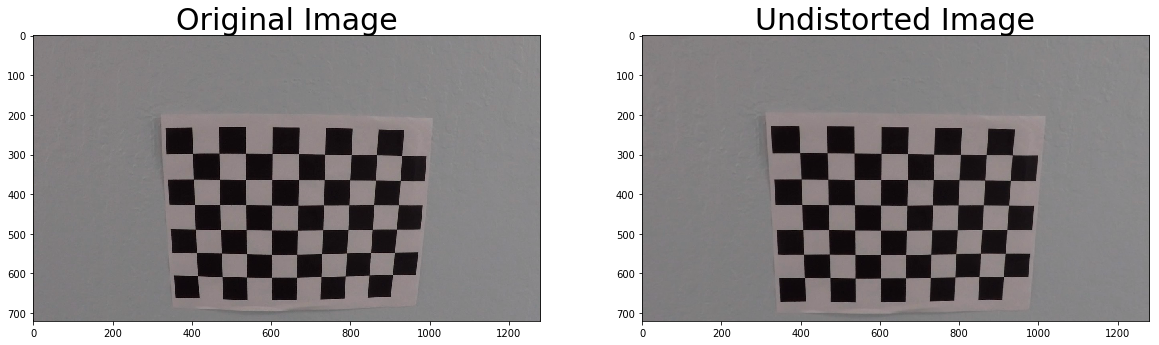

In [14]:
%matplotlib inline
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_cal_image)
ax2.set_title('Undistorted Image', fontsize=30)

#### Here, we are plotting a sample of original image and warped image

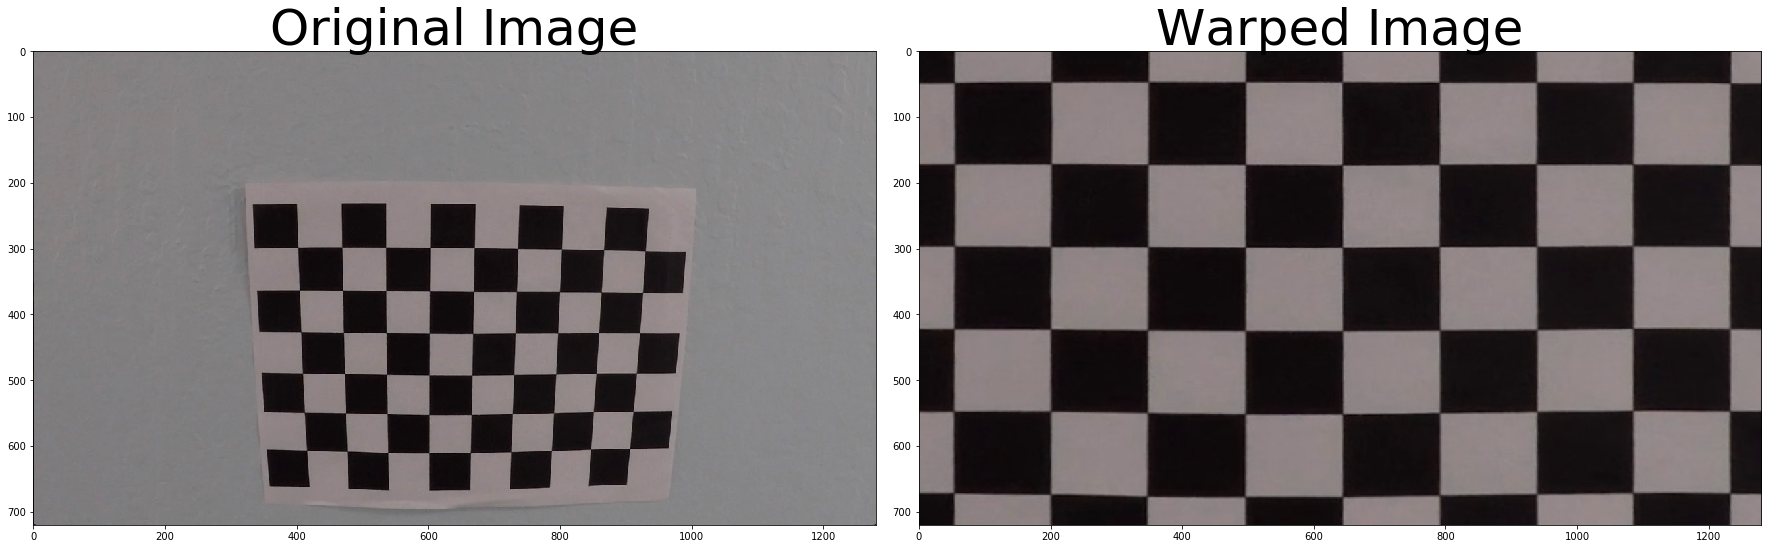

In [15]:
# Visualize perpective transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_image)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Algorithm Pipeline:
This is our algorithm pipeline entry point.
This function wraps and calls all the functions needed to detect the lane lines on the road of an image

In [16]:
images_count = 0
lane = Lane_Features()

def algorithm_pipeline(image, test_images_mode):
    """
    Descrition:
        Wrapper for all the functions needed to detect lane line on the road
    Paramteres:
        image: Image under processing
        test_images_mode: A flag to differentiate between test images and video processing
    Output:
        result_image: An image with lane line detected, curvature, and vehicle distance from lane center        
    """
    global images_count

    activate_sliding_window = False
    
    leftx = lane.leftx
    lefty = lane.lefty
    rightx = lane.rightx
    righty = lane.righty
    left_fit = lane.left_fit
    right_fit = lane.right_fit
    left_fitx = lane.left_fitx
    right_fitx = lane.right_fitx
    ploty = lane.ploty
        
    undistorted_image = undistort(image, mtx, dist, test_images_mode=test_images_mode)
    
    combined_binary_image = sobelx_s_l_channels_thresholds(undistorted_image, test_images_mode=test_images_mode)
    
    roi_image = region_of_interest(combined_binary_image, image.shape, test_images_mode=test_images_mode)

    warped_perspective_roi_image, perspective_M, inv_perspective_M = warp_image_perspective(roi_image, test_images_mode=test_images_mode)
        
    try:
        if( (np.min(leftx) < 200) | (np.max(rightx) > 1000) ):
            activate_sliding_window = True
    except ValueError:
        activate_sliding_window = True
        pass
    
    if( (test_images_mode == True) | (activate_sliding_window == True) ):
        output_lane_lines_image, leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty = search_for_lane_lines(warped_perspective_roi_image, test_images_mode=test_images_mode)
        print("Sliding Window Done")
        
    else:
        output_lane_lines_image, leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty = search_for_lane_lines_based_on_previous_frame(warped_perspective_roi_image, left_fit, right_fit)
        print("Search based on prev frame Done")
    
    
    result_image = calculate_lane_curvature_and_vehicle_position(undistorted_image, output_lane_lines_image, leftx, lefty, ploty, rightx, righty,left_fitx, right_fitx, inv_perspective_M, test_images_mode=test_images_mode) 
    
    images_count = images_count + 1
    
    lane.leftx = leftx
    lane.lefty = lefty
    lane.rightx = rightx
    lane.righty = righty
    lane.left_fit = left_fit
    lane.right_fit = right_fit
    lane.left_fitx = left_fitx
    lane.right_fitx = right_fitx
    lane.ploty = ploty
    
    activate_sliding_window = False
    
    return result_image
    
print("Done")

Done


### Test on Test Images

In [17]:
# Make a list of test images
test_images = glob.glob('test_images/*.jpg')
print(test_images)

# Step through the list and test for perspective transform
for idx, fname in enumerate(test_images):
    img = cv2.imread(fname)
    
    algorithm_pipeline(img, test_images_mode=True)
    

['test_images/test2.jpg', 'test_images/test5.jpg', 'test_images/straight_lines1.jpg', 'test_images/test4.jpg', 'test_images/straight_lines2.jpg', 'test_images/test3.jpg', 'test_images/test6.jpg', 'test_images/test1.jpg']
Sliding Window Done
Sliding Window Done
Sliding Window Done
Sliding Window Done
Sliding Window Done
Sliding Window Done
Sliding Window Done
Sliding Window Done


### Here, we reset the `images_count` and `lane` class objects for the video processing

In [18]:
images_count = 0
lane.__init__()

### This is a function for calling the algorithm pipeline for video processing

In [19]:
def process_image(image):

    result = algorithm_pipeline(image, test_images_mode=False)
    
    return result

### Test on Test Video

In [20]:
white_output = 'test_video_output/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video/project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Sliding Window Done
[MoviePy] >>>> Building video test_video_output/project_video_output.mp4
[MoviePy] Writing video test_video_output/project_video_output.mp4


  0%|          | 1/1261 [00:00<10:32,  1.99it/s]

Sliding Window Done


  0%|          | 2/1261 [00:01<10:33,  1.99it/s]

Sliding Window Done


  0%|          | 3/1261 [00:01<10:31,  1.99it/s]

Search based on prev frame Done


  0%|          | 4/1261 [00:02<10:38,  1.97it/s]

Search based on prev frame Done


  0%|          | 5/1261 [00:02<10:35,  1.98it/s]

Search based on prev frame Done


  0%|          | 6/1261 [00:03<11:05,  1.89it/s]

Search based on prev frame Done


  1%|          | 7/1261 [00:03<11:29,  1.82it/s]

Search based on prev frame Done


  1%|          | 8/1261 [00:04<12:41,  1.65it/s]

Search based on prev frame Done


  1%|          | 9/1261 [00:05<13:36,  1.53it/s]

Search based on prev frame Done


  1%|          | 10/1261 [00:05<12:38,  1.65it/s]

Search based on prev frame Done


  1%|          | 11/1261 [00:06<12:21,  1.69it/s]

Search based on prev frame Done


  1%|          | 12/1261 [00:07<14:39,  1.42it/s]

Search based on prev frame Done


  1%|          | 13/1261 [00:08<15:58,  1.30it/s]

Search based on prev frame Done


  1%|          | 14/1261 [00:08<15:18,  1.36it/s]

Search based on prev frame Done


  1%|          | 15/1261 [00:09<13:56,  1.49it/s]

Search based on prev frame Done


  1%|▏         | 16/1261 [00:09<13:04,  1.59it/s]

Search based on prev frame Done


  1%|▏         | 17/1261 [00:10<13:24,  1.55it/s]

Search based on prev frame Done


  1%|▏         | 18/1261 [00:11<14:49,  1.40it/s]

Search based on prev frame Done


  2%|▏         | 19/1261 [00:12<14:30,  1.43it/s]

Search based on prev frame Done


  2%|▏         | 20/1261 [00:12<13:35,  1.52it/s]

Search based on prev frame Done


  2%|▏         | 21/1261 [00:13<13:56,  1.48it/s]

Search based on prev frame Done


  2%|▏         | 22/1261 [00:13<13:02,  1.58it/s]

Search based on prev frame Done


  2%|▏         | 23/1261 [00:14<12:36,  1.64it/s]

Search based on prev frame Done


  2%|▏         | 24/1261 [00:14<12:00,  1.72it/s]

Search based on prev frame Done


  2%|▏         | 25/1261 [00:15<11:26,  1.80it/s]

Search based on prev frame Done


  2%|▏         | 26/1261 [00:15<11:09,  1.84it/s]

Search based on prev frame Done


  2%|▏         | 27/1261 [00:16<10:52,  1.89it/s]

Search based on prev frame Done


  2%|▏         | 28/1261 [00:17<10:51,  1.89it/s]

Search based on prev frame Done


  2%|▏         | 29/1261 [00:17<10:48,  1.90it/s]

Search based on prev frame Done


  2%|▏         | 30/1261 [00:18<10:48,  1.90it/s]

Search based on prev frame Done


  2%|▏         | 31/1261 [00:18<10:36,  1.93it/s]

Search based on prev frame Done


  3%|▎         | 32/1261 [00:19<10:37,  1.93it/s]

Search based on prev frame Done


  3%|▎         | 33/1261 [00:19<10:49,  1.89it/s]

Search based on prev frame Done


  3%|▎         | 34/1261 [00:20<10:59,  1.86it/s]

Search based on prev frame Done


  3%|▎         | 35/1261 [00:20<11:44,  1.74it/s]

Search based on prev frame Done


  3%|▎         | 36/1261 [00:21<11:34,  1.76it/s]

Sliding Window Done


  3%|▎         | 37/1261 [00:21<11:09,  1.83it/s]

Search based on prev frame Done


  3%|▎         | 38/1261 [00:22<13:01,  1.57it/s]

Search based on prev frame Done


  3%|▎         | 39/1261 [00:23<13:12,  1.54it/s]

Search based on prev frame Done


  3%|▎         | 40/1261 [00:23<12:15,  1.66it/s]

Search based on prev frame Done


  3%|▎         | 41/1261 [00:24<11:29,  1.77it/s]

Search based on prev frame Done


  3%|▎         | 42/1261 [00:24<10:56,  1.86it/s]

Search based on prev frame Done


  3%|▎         | 43/1261 [00:25<11:25,  1.78it/s]

Search based on prev frame Done


  3%|▎         | 44/1261 [00:25<10:52,  1.86it/s]

Search based on prev frame Done


  4%|▎         | 45/1261 [00:26<10:33,  1.92it/s]

Search based on prev frame Done


  4%|▎         | 46/1261 [00:26<10:15,  1.97it/s]

Search based on prev frame Done


  4%|▎         | 47/1261 [00:27<10:11,  1.98it/s]

Search based on prev frame Done


  4%|▍         | 48/1261 [00:27<10:22,  1.95it/s]

Search based on prev frame Done


  4%|▍         | 49/1261 [00:28<10:20,  1.95it/s]

Search based on prev frame Done


  4%|▍         | 50/1261 [00:28<10:15,  1.97it/s]

Search based on prev frame Done


  4%|▍         | 51/1261 [00:29<11:09,  1.81it/s]

Search based on prev frame Done


  4%|▍         | 52/1261 [00:30<10:59,  1.83it/s]

Search based on prev frame Done


  4%|▍         | 53/1261 [00:30<11:14,  1.79it/s]

Search based on prev frame Done


  4%|▍         | 54/1261 [00:31<11:05,  1.81it/s]

Search based on prev frame Done


  4%|▍         | 55/1261 [00:32<12:11,  1.65it/s]

Search based on prev frame Done


  4%|▍         | 56/1261 [00:32<12:33,  1.60it/s]

Search based on prev frame Done


  5%|▍         | 57/1261 [00:33<14:36,  1.37it/s]

Search based on prev frame Done


  5%|▍         | 58/1261 [00:34<13:40,  1.47it/s]

Search based on prev frame Done


  5%|▍         | 59/1261 [00:34<12:49,  1.56it/s]

Search based on prev frame Done


  5%|▍         | 60/1261 [00:35<12:30,  1.60it/s]

Search based on prev frame Done


  5%|▍         | 61/1261 [00:35<12:03,  1.66it/s]

Search based on prev frame Done


  5%|▍         | 62/1261 [00:36<11:38,  1.72it/s]

Search based on prev frame Done


  5%|▍         | 63/1261 [00:36<11:17,  1.77it/s]

Search based on prev frame Done


  5%|▌         | 64/1261 [00:37<12:24,  1.61it/s]

Search based on prev frame Done


  5%|▌         | 65/1261 [00:38<11:54,  1.67it/s]

Search based on prev frame Done


  5%|▌         | 66/1261 [00:38<11:28,  1.74it/s]

Search based on prev frame Done


  5%|▌         | 67/1261 [00:39<12:24,  1.60it/s]

Search based on prev frame Done


  5%|▌         | 68/1261 [00:40<13:07,  1.51it/s]

Search based on prev frame Done


  5%|▌         | 69/1261 [00:40<12:55,  1.54it/s]

Search based on prev frame Done


  6%|▌         | 70/1261 [00:41<12:10,  1.63it/s]

Search based on prev frame Done


  6%|▌         | 71/1261 [00:41<11:37,  1.71it/s]

Search based on prev frame Done


  6%|▌         | 72/1261 [00:42<11:59,  1.65it/s]

Search based on prev frame Done


  6%|▌         | 73/1261 [00:43<12:06,  1.63it/s]

Search based on prev frame Done


  6%|▌         | 74/1261 [00:43<12:20,  1.60it/s]

Search based on prev frame Done


  6%|▌         | 75/1261 [00:44<11:34,  1.71it/s]

Search based on prev frame Done


  6%|▌         | 76/1261 [00:44<11:35,  1.70it/s]

Search based on prev frame Done


  6%|▌         | 77/1261 [00:45<12:17,  1.61it/s]

Search based on prev frame Done


  6%|▌         | 78/1261 [00:46<11:44,  1.68it/s]

Search based on prev frame Done


  6%|▋         | 79/1261 [00:47<13:12,  1.49it/s]

Search based on prev frame Done


  6%|▋         | 80/1261 [00:47<13:28,  1.46it/s]

Search based on prev frame Done


  6%|▋         | 81/1261 [00:48<13:23,  1.47it/s]

Search based on prev frame Done


  7%|▋         | 82/1261 [00:48<12:21,  1.59it/s]

Search based on prev frame Done


  7%|▋         | 83/1261 [00:49<12:21,  1.59it/s]

Search based on prev frame Done


  7%|▋         | 84/1261 [00:50<11:43,  1.67it/s]

Search based on prev frame Done


  7%|▋         | 85/1261 [00:50<11:09,  1.76it/s]

Search based on prev frame Done


  7%|▋         | 86/1261 [00:51<11:47,  1.66it/s]

Search based on prev frame Done


  7%|▋         | 87/1261 [00:51<11:11,  1.75it/s]

Search based on prev frame Done


  7%|▋         | 88/1261 [00:52<11:35,  1.69it/s]

Search based on prev frame Done


  7%|▋         | 89/1261 [00:52<11:05,  1.76it/s]

Search based on prev frame Done


  7%|▋         | 90/1261 [00:53<10:45,  1.81it/s]

Search based on prev frame Done


  7%|▋         | 91/1261 [00:53<10:29,  1.86it/s]

Search based on prev frame Done


  7%|▋         | 92/1261 [00:54<10:22,  1.88it/s]

Search based on prev frame Done


  7%|▋         | 93/1261 [00:54<10:09,  1.92it/s]

Search based on prev frame Done


  7%|▋         | 94/1261 [00:55<09:57,  1.95it/s]

Search based on prev frame Done


  8%|▊         | 95/1261 [00:55<09:53,  1.96it/s]

Search based on prev frame Done


  8%|▊         | 96/1261 [00:56<09:54,  1.96it/s]

Search based on prev frame Done


  8%|▊         | 97/1261 [00:56<09:56,  1.95it/s]

Search based on prev frame Done


  8%|▊         | 98/1261 [00:57<10:34,  1.83it/s]

Search based on prev frame Done


  8%|▊         | 99/1261 [00:58<10:33,  1.83it/s]

Search based on prev frame Done


  8%|▊         | 100/1261 [00:58<11:42,  1.65it/s]

Search based on prev frame Done


  8%|▊         | 101/1261 [00:59<11:26,  1.69it/s]

Search based on prev frame Done


  8%|▊         | 102/1261 [00:59<11:00,  1.76it/s]

Search based on prev frame Done


  8%|▊         | 103/1261 [01:00<12:34,  1.54it/s]

Search based on prev frame Done


  8%|▊         | 104/1261 [01:01<14:00,  1.38it/s]

Search based on prev frame Done


  8%|▊         | 105/1261 [01:02<12:55,  1.49it/s]

Search based on prev frame Done


  8%|▊         | 106/1261 [01:02<12:01,  1.60it/s]

Search based on prev frame Done


  8%|▊         | 107/1261 [01:03<11:21,  1.69it/s]

Search based on prev frame Done


  9%|▊         | 108/1261 [01:03<10:55,  1.76it/s]

Search based on prev frame Done


  9%|▊         | 109/1261 [01:04<10:32,  1.82it/s]

Search based on prev frame Done


  9%|▊         | 110/1261 [01:04<10:27,  1.83it/s]

Search based on prev frame Done


  9%|▉         | 111/1261 [01:05<10:12,  1.88it/s]

Search based on prev frame Done


  9%|▉         | 112/1261 [01:05<10:09,  1.89it/s]

Search based on prev frame Done


  9%|▉         | 113/1261 [01:06<10:08,  1.89it/s]

Search based on prev frame Done


  9%|▉         | 114/1261 [01:06<09:56,  1.92it/s]

Search based on prev frame Done


  9%|▉         | 115/1261 [01:07<10:23,  1.84it/s]

Search based on prev frame Done


  9%|▉         | 116/1261 [01:08<10:39,  1.79it/s]

Search based on prev frame Done


  9%|▉         | 117/1261 [01:08<10:46,  1.77it/s]

Search based on prev frame Done


  9%|▉         | 118/1261 [01:09<10:27,  1.82it/s]

Search based on prev frame Done


  9%|▉         | 119/1261 [01:09<10:17,  1.85it/s]

Search based on prev frame Done


 10%|▉         | 120/1261 [01:10<10:13,  1.86it/s]

Search based on prev frame Done


 10%|▉         | 121/1261 [01:10<10:07,  1.88it/s]

Search based on prev frame Done


 10%|▉         | 122/1261 [01:11<09:57,  1.91it/s]

Search based on prev frame Done


 10%|▉         | 123/1261 [01:11<10:09,  1.87it/s]

Search based on prev frame Done


 10%|▉         | 124/1261 [01:12<10:03,  1.89it/s]

Search based on prev frame Done


 10%|▉         | 125/1261 [01:12<09:57,  1.90it/s]

Search based on prev frame Done


 10%|▉         | 126/1261 [01:13<09:46,  1.94it/s]

Search based on prev frame Done


 10%|█         | 127/1261 [01:13<09:35,  1.97it/s]

Search based on prev frame Done


 10%|█         | 128/1261 [01:14<09:39,  1.96it/s]

Search based on prev frame Done


 10%|█         | 129/1261 [01:14<09:32,  1.98it/s]

Search based on prev frame Done


 10%|█         | 130/1261 [01:15<09:25,  2.00it/s]

Search based on prev frame Done


 10%|█         | 131/1261 [01:15<09:30,  1.98it/s]

Search based on prev frame Done


 10%|█         | 132/1261 [01:16<10:25,  1.81it/s]

Search based on prev frame Done


 11%|█         | 133/1261 [01:17<10:47,  1.74it/s]

Search based on prev frame Done


 11%|█         | 134/1261 [01:17<10:43,  1.75it/s]

Search based on prev frame Done


 11%|█         | 135/1261 [01:18<10:46,  1.74it/s]

Search based on prev frame Done


 11%|█         | 136/1261 [01:18<10:57,  1.71it/s]

Search based on prev frame Done


 11%|█         | 137/1261 [01:19<10:35,  1.77it/s]

Search based on prev frame Done


 11%|█         | 138/1261 [01:19<10:13,  1.83it/s]

Search based on prev frame Done


 11%|█         | 139/1261 [01:20<10:08,  1.84it/s]

Search based on prev frame Done


 11%|█         | 140/1261 [01:21<10:38,  1.76it/s]

Search based on prev frame Done


 11%|█         | 141/1261 [01:21<10:22,  1.80it/s]

Search based on prev frame Done


 11%|█▏        | 142/1261 [01:22<10:11,  1.83it/s]

Search based on prev frame Done


 11%|█▏        | 143/1261 [01:22<09:49,  1.89it/s]

Search based on prev frame Done


 11%|█▏        | 144/1261 [01:23<09:44,  1.91it/s]

Search based on prev frame Done


 11%|█▏        | 145/1261 [01:23<09:38,  1.93it/s]

Search based on prev frame Done


 12%|█▏        | 146/1261 [01:24<09:34,  1.94it/s]

Search based on prev frame Done


 12%|█▏        | 147/1261 [01:24<09:37,  1.93it/s]

Search based on prev frame Done


 12%|█▏        | 148/1261 [01:25<09:57,  1.86it/s]

Search based on prev frame Done


 12%|█▏        | 149/1261 [01:25<09:46,  1.90it/s]

Search based on prev frame Done


 12%|█▏        | 150/1261 [01:26<09:45,  1.90it/s]

Search based on prev frame Done


 12%|█▏        | 151/1261 [01:26<09:54,  1.87it/s]

Search based on prev frame Done


 12%|█▏        | 152/1261 [01:27<09:48,  1.89it/s]

Search based on prev frame Done


 12%|█▏        | 153/1261 [01:27<09:39,  1.91it/s]

Search based on prev frame Done


 12%|█▏        | 154/1261 [01:28<09:28,  1.95it/s]

Search based on prev frame Done


 12%|█▏        | 155/1261 [01:28<09:21,  1.97it/s]

Search based on prev frame Done


 12%|█▏        | 156/1261 [01:29<09:33,  1.93it/s]

Search based on prev frame Done


 12%|█▏        | 157/1261 [01:29<09:25,  1.95it/s]

Search based on prev frame Done


 13%|█▎        | 158/1261 [01:30<09:19,  1.97it/s]

Search based on prev frame Done


 13%|█▎        | 159/1261 [01:30<09:18,  1.97it/s]

Search based on prev frame Done


 13%|█▎        | 160/1261 [01:31<09:18,  1.97it/s]

Search based on prev frame Done


 13%|█▎        | 161/1261 [01:31<09:11,  2.00it/s]

Search based on prev frame Done


 13%|█▎        | 162/1261 [01:32<09:13,  1.99it/s]

Sliding Window Done


 13%|█▎        | 163/1261 [01:32<09:07,  2.01it/s]

Search based on prev frame Done


 13%|█▎        | 164/1261 [01:33<09:08,  2.00it/s]

Search based on prev frame Done


 13%|█▎        | 165/1261 [01:34<09:49,  1.86it/s]

Search based on prev frame Done


 13%|█▎        | 166/1261 [01:34<09:37,  1.89it/s]

Search based on prev frame Done


 13%|█▎        | 167/1261 [01:35<09:27,  1.93it/s]

Search based on prev frame Done


 13%|█▎        | 168/1261 [01:35<09:34,  1.90it/s]

Search based on prev frame Done


 13%|█▎        | 169/1261 [01:36<09:24,  1.93it/s]

Search based on prev frame Done


 13%|█▎        | 170/1261 [01:36<09:51,  1.85it/s]

Search based on prev frame Done


 14%|█▎        | 171/1261 [01:37<09:36,  1.89it/s]

Search based on prev frame Done


 14%|█▎        | 172/1261 [01:37<09:32,  1.90it/s]

Search based on prev frame Done


 14%|█▎        | 173/1261 [01:38<09:20,  1.94it/s]

Search based on prev frame Done


 14%|█▍        | 174/1261 [01:38<09:12,  1.97it/s]

Search based on prev frame Done


 14%|█▍        | 175/1261 [01:39<09:04,  1.99it/s]

Search based on prev frame Done


 14%|█▍        | 176/1261 [01:39<09:25,  1.92it/s]

Search based on prev frame Done


 14%|█▍        | 177/1261 [01:40<09:21,  1.93it/s]

Sliding Window Done


 14%|█▍        | 178/1261 [01:40<09:10,  1.97it/s]

Search based on prev frame Done


 14%|█▍        | 179/1261 [01:41<09:03,  1.99it/s]

Search based on prev frame Done


 14%|█▍        | 180/1261 [01:41<09:11,  1.96it/s]

Search based on prev frame Done


 14%|█▍        | 181/1261 [01:42<09:05,  1.98it/s]

Search based on prev frame Done


 14%|█▍        | 182/1261 [01:42<08:56,  2.01it/s]

Search based on prev frame Done


 15%|█▍        | 183/1261 [01:43<08:54,  2.02it/s]

Search based on prev frame Done


 15%|█▍        | 184/1261 [01:43<09:39,  1.86it/s]

Search based on prev frame Done


 15%|█▍        | 185/1261 [01:44<09:20,  1.92it/s]

Search based on prev frame Done


 15%|█▍        | 186/1261 [01:44<09:43,  1.84it/s]

Search based on prev frame Done


 15%|█▍        | 187/1261 [01:45<09:39,  1.85it/s]

Sliding Window Done


 15%|█▍        | 188/1261 [01:45<09:34,  1.87it/s]

Sliding Window Done


 15%|█▍        | 189/1261 [01:46<09:24,  1.90it/s]

Sliding Window Done


 15%|█▌        | 190/1261 [01:46<09:12,  1.94it/s]

Sliding Window Done


 15%|█▌        | 191/1261 [01:47<09:02,  1.97it/s]

Sliding Window Done


 15%|█▌        | 192/1261 [01:47<09:06,  1.96it/s]

Sliding Window Done


 15%|█▌        | 193/1261 [01:48<09:03,  1.97it/s]

Sliding Window Done


 15%|█▌        | 194/1261 [01:48<08:58,  1.98it/s]

Sliding Window Done


 15%|█▌        | 195/1261 [01:49<09:00,  1.97it/s]

Sliding Window Done


 16%|█▌        | 196/1261 [01:49<09:04,  1.95it/s]

Search based on prev frame Done


 16%|█▌        | 197/1261 [01:50<09:01,  1.96it/s]

Search based on prev frame Done


 16%|█▌        | 198/1261 [01:50<08:53,  1.99it/s]

Search based on prev frame Done


 16%|█▌        | 199/1261 [01:51<09:02,  1.96it/s]

Search based on prev frame Done


 16%|█▌        | 200/1261 [01:52<09:05,  1.94it/s]

Search based on prev frame Done


 16%|█▌        | 201/1261 [01:52<09:07,  1.94it/s]

Search based on prev frame Done


 16%|█▌        | 202/1261 [01:53<09:04,  1.94it/s]

Search based on prev frame Done


 16%|█▌        | 203/1261 [01:53<09:14,  1.91it/s]

Search based on prev frame Done


 16%|█▌        | 204/1261 [01:54<09:27,  1.86it/s]

Search based on prev frame Done


 16%|█▋        | 205/1261 [01:54<09:15,  1.90it/s]

Search based on prev frame Done


 16%|█▋        | 206/1261 [01:55<09:03,  1.94it/s]

Search based on prev frame Done


 16%|█▋        | 207/1261 [01:55<08:54,  1.97it/s]

Search based on prev frame Done


 16%|█▋        | 208/1261 [01:56<08:54,  1.97it/s]

Search based on prev frame Done


 17%|█▋        | 209/1261 [01:56<08:45,  2.00it/s]

Search based on prev frame Done


 17%|█▋        | 210/1261 [01:57<08:47,  1.99it/s]

Search based on prev frame Done


 17%|█▋        | 211/1261 [01:57<08:38,  2.03it/s]

Search based on prev frame Done


 17%|█▋        | 212/1261 [01:58<08:42,  2.01it/s]

Search based on prev frame Done


 17%|█▋        | 213/1261 [01:58<08:41,  2.01it/s]

Search based on prev frame Done


 17%|█▋        | 214/1261 [01:59<08:46,  1.99it/s]

Search based on prev frame Done


 17%|█▋        | 215/1261 [01:59<08:42,  2.00it/s]

Search based on prev frame Done


 17%|█▋        | 216/1261 [02:00<08:50,  1.97it/s]

Search based on prev frame Done


 17%|█▋        | 217/1261 [02:00<08:44,  1.99it/s]

Search based on prev frame Done


 17%|█▋        | 218/1261 [02:01<08:46,  1.98it/s]

Search based on prev frame Done


 17%|█▋        | 219/1261 [02:01<08:45,  1.98it/s]

Search based on prev frame Done


 17%|█▋        | 220/1261 [02:02<08:52,  1.95it/s]

Search based on prev frame Done


 18%|█▊        | 221/1261 [02:02<09:05,  1.91it/s]

Sliding Window Done


 18%|█▊        | 222/1261 [02:03<10:21,  1.67it/s]

Sliding Window Done


 18%|█▊        | 223/1261 [02:04<10:27,  1.65it/s]

Search based on prev frame Done


 18%|█▊        | 224/1261 [02:04<10:05,  1.71it/s]

Sliding Window Done


 18%|█▊        | 225/1261 [02:05<09:34,  1.80it/s]

Search based on prev frame Done


 18%|█▊        | 226/1261 [02:05<09:14,  1.87it/s]

Search based on prev frame Done


 18%|█▊        | 227/1261 [02:06<09:24,  1.83it/s]

Search based on prev frame Done


 18%|█▊        | 228/1261 [02:06<09:14,  1.86it/s]

Search based on prev frame Done


 18%|█▊        | 229/1261 [02:07<09:05,  1.89it/s]

Search based on prev frame Done


 18%|█▊        | 230/1261 [02:07<09:03,  1.90it/s]

Search based on prev frame Done


 18%|█▊        | 231/1261 [02:08<08:54,  1.93it/s]

Sliding Window Done


 18%|█▊        | 232/1261 [02:08<08:53,  1.93it/s]

Sliding Window Done


 18%|█▊        | 233/1261 [02:09<09:21,  1.83it/s]

Sliding Window Done


 19%|█▊        | 234/1261 [02:09<09:18,  1.84it/s]

Sliding Window Done


 19%|█▊        | 235/1261 [02:10<09:04,  1.89it/s]

Sliding Window Done


 19%|█▊        | 236/1261 [02:10<09:05,  1.88it/s]

Sliding Window Done


 19%|█▉        | 237/1261 [02:11<08:52,  1.92it/s]

Sliding Window Done


 19%|█▉        | 238/1261 [02:11<08:45,  1.95it/s]

Sliding Window Done


 19%|█▉        | 239/1261 [02:12<09:12,  1.85it/s]

Sliding Window Done


 19%|█▉        | 240/1261 [02:13<09:18,  1.83it/s]

Sliding Window Done


 19%|█▉        | 241/1261 [02:13<09:20,  1.82it/s]

Sliding Window Done


 19%|█▉        | 242/1261 [02:14<09:00,  1.88it/s]

Sliding Window Done


 19%|█▉        | 243/1261 [02:14<08:49,  1.92it/s]

Sliding Window Done


 19%|█▉        | 244/1261 [02:15<08:52,  1.91it/s]

Sliding Window Done


 19%|█▉        | 245/1261 [02:15<08:39,  1.96it/s]

Sliding Window Done


 20%|█▉        | 246/1261 [02:16<08:35,  1.97it/s]

Sliding Window Done


 20%|█▉        | 247/1261 [02:16<08:56,  1.89it/s]

Sliding Window Done


 20%|█▉        | 248/1261 [02:17<09:06,  1.85it/s]

Sliding Window Done


 20%|█▉        | 249/1261 [02:17<09:09,  1.84it/s]

Sliding Window Done


 20%|█▉        | 250/1261 [02:18<09:22,  1.80it/s]

Sliding Window Done


 20%|█▉        | 251/1261 [02:19<10:55,  1.54it/s]

Sliding Window Done


 20%|█▉        | 252/1261 [02:19<10:35,  1.59it/s]

Search based on prev frame Done


 20%|██        | 253/1261 [02:20<10:01,  1.68it/s]

Search based on prev frame Done


 20%|██        | 254/1261 [02:20<09:31,  1.76it/s]

Search based on prev frame Done


 20%|██        | 255/1261 [02:21<09:14,  1.81it/s]

Search based on prev frame Done


 20%|██        | 256/1261 [02:21<09:04,  1.85it/s]

Search based on prev frame Done


 20%|██        | 257/1261 [02:22<08:51,  1.89it/s]

Search based on prev frame Done


 20%|██        | 258/1261 [02:22<08:45,  1.91it/s]

Search based on prev frame Done


 21%|██        | 259/1261 [02:23<08:34,  1.95it/s]

Search based on prev frame Done


 21%|██        | 260/1261 [02:24<08:44,  1.91it/s]

Search based on prev frame Done


 21%|██        | 261/1261 [02:24<08:42,  1.92it/s]

Search based on prev frame Done


 21%|██        | 262/1261 [02:25<08:35,  1.94it/s]

Search based on prev frame Done


 21%|██        | 263/1261 [02:25<08:29,  1.96it/s]

Search based on prev frame Done


 21%|██        | 264/1261 [02:26<08:39,  1.92it/s]

Search based on prev frame Done


 21%|██        | 265/1261 [02:26<08:36,  1.93it/s]

Search based on prev frame Done


 21%|██        | 266/1261 [02:27<08:25,  1.97it/s]

Search based on prev frame Done


 21%|██        | 267/1261 [02:27<08:25,  1.97it/s]

Search based on prev frame Done


 21%|██▏       | 268/1261 [02:28<08:29,  1.95it/s]

Search based on prev frame Done


 21%|██▏       | 269/1261 [02:28<08:32,  1.93it/s]

Search based on prev frame Done


 21%|██▏       | 270/1261 [02:29<08:50,  1.87it/s]

Search based on prev frame Done


 21%|██▏       | 271/1261 [02:29<09:27,  1.75it/s]

Search based on prev frame Done


 22%|██▏       | 272/1261 [02:30<10:03,  1.64it/s]

Search based on prev frame Done


 22%|██▏       | 273/1261 [02:31<09:57,  1.65it/s]

Search based on prev frame Done


 22%|██▏       | 274/1261 [02:31<11:01,  1.49it/s]

Search based on prev frame Done


 22%|██▏       | 275/1261 [02:32<10:44,  1.53it/s]

Search based on prev frame Done


 22%|██▏       | 276/1261 [02:33<10:23,  1.58it/s]

Search based on prev frame Done


 22%|██▏       | 277/1261 [02:33<09:53,  1.66it/s]

Search based on prev frame Done


 22%|██▏       | 278/1261 [02:34<09:42,  1.69it/s]

Search based on prev frame Done


 22%|██▏       | 279/1261 [02:34<09:33,  1.71it/s]

Search based on prev frame Done


 22%|██▏       | 280/1261 [02:35<09:13,  1.77it/s]

Search based on prev frame Done


 22%|██▏       | 281/1261 [02:35<08:50,  1.85it/s]

Search based on prev frame Done


 22%|██▏       | 282/1261 [02:36<08:32,  1.91it/s]

Search based on prev frame Done


 22%|██▏       | 283/1261 [02:36<08:26,  1.93it/s]

Search based on prev frame Done


 23%|██▎       | 284/1261 [02:37<08:25,  1.93it/s]

Search based on prev frame Done


 23%|██▎       | 285/1261 [02:37<08:14,  1.97it/s]

Search based on prev frame Done


 23%|██▎       | 286/1261 [02:38<08:22,  1.94it/s]

Search based on prev frame Done


 23%|██▎       | 287/1261 [02:38<08:21,  1.94it/s]

Search based on prev frame Done


 23%|██▎       | 288/1261 [02:39<08:20,  1.94it/s]

Search based on prev frame Done


 23%|██▎       | 289/1261 [02:39<08:22,  1.93it/s]

Search based on prev frame Done


 23%|██▎       | 290/1261 [02:40<08:14,  1.96it/s]

Search based on prev frame Done


 23%|██▎       | 291/1261 [02:40<08:11,  1.97it/s]

Search based on prev frame Done


 23%|██▎       | 292/1261 [02:41<08:18,  1.94it/s]

Search based on prev frame Done


 23%|██▎       | 293/1261 [02:42<08:28,  1.90it/s]

Search based on prev frame Done


 23%|██▎       | 294/1261 [02:42<08:17,  1.94it/s]

Search based on prev frame Done


 23%|██▎       | 295/1261 [02:42<08:13,  1.96it/s]

Search based on prev frame Done


 23%|██▎       | 296/1261 [02:43<08:07,  1.98it/s]

Search based on prev frame Done


 24%|██▎       | 297/1261 [02:43<08:02,  2.00it/s]

Search based on prev frame Done


 24%|██▎       | 298/1261 [02:44<08:08,  1.97it/s]

Search based on prev frame Done


 24%|██▎       | 299/1261 [02:44<08:02,  2.00it/s]

Search based on prev frame Done


 24%|██▍       | 300/1261 [02:45<07:58,  2.01it/s]

Search based on prev frame Done


 24%|██▍       | 301/1261 [02:45<08:00,  2.00it/s]

Search based on prev frame Done


 24%|██▍       | 302/1261 [02:46<08:07,  1.97it/s]

Search based on prev frame Done


 24%|██▍       | 303/1261 [02:47<08:25,  1.90it/s]

Search based on prev frame Done


 24%|██▍       | 304/1261 [02:47<08:18,  1.92it/s]

Sliding Window Done


 24%|██▍       | 305/1261 [02:48<08:10,  1.95it/s]

Search based on prev frame Done


 24%|██▍       | 306/1261 [02:48<08:14,  1.93it/s]

Search based on prev frame Done


 24%|██▍       | 307/1261 [02:49<08:11,  1.94it/s]

Search based on prev frame Done


 24%|██▍       | 308/1261 [02:49<08:07,  1.95it/s]

Search based on prev frame Done


 25%|██▍       | 309/1261 [02:50<08:02,  1.97it/s]

Search based on prev frame Done


 25%|██▍       | 310/1261 [02:50<08:05,  1.96it/s]

Search based on prev frame Done


 25%|██▍       | 311/1261 [02:51<08:01,  1.97it/s]

Search based on prev frame Done


 25%|██▍       | 312/1261 [02:51<07:58,  1.98it/s]

Search based on prev frame Done


 25%|██▍       | 313/1261 [02:52<07:59,  1.98it/s]

Search based on prev frame Done


 25%|██▍       | 314/1261 [02:52<08:00,  1.97it/s]

Search based on prev frame Done


 25%|██▍       | 315/1261 [02:53<07:59,  1.97it/s]

Search based on prev frame Done


 25%|██▌       | 316/1261 [02:53<07:54,  1.99it/s]

Search based on prev frame Done


 25%|██▌       | 317/1261 [02:54<07:49,  2.01it/s]

Search based on prev frame Done


 25%|██▌       | 318/1261 [02:54<07:53,  1.99it/s]

Search based on prev frame Done


 25%|██▌       | 319/1261 [02:55<07:54,  1.98it/s]

Search based on prev frame Done


 25%|██▌       | 320/1261 [02:55<07:52,  1.99it/s]

Search based on prev frame Done


 25%|██▌       | 321/1261 [02:56<07:52,  1.99it/s]

Search based on prev frame Done


 26%|██▌       | 322/1261 [02:56<08:03,  1.94it/s]

Search based on prev frame Done


 26%|██▌       | 323/1261 [02:57<07:58,  1.96it/s]

Search based on prev frame Done


 26%|██▌       | 324/1261 [02:57<07:53,  1.98it/s]

Search based on prev frame Done


 26%|██▌       | 325/1261 [02:58<07:54,  1.97it/s]

Search based on prev frame Done


 26%|██▌       | 326/1261 [02:58<07:58,  1.96it/s]

Search based on prev frame Done


 26%|██▌       | 327/1261 [02:59<07:53,  1.97it/s]

Search based on prev frame Done


 26%|██▌       | 328/1261 [02:59<07:49,  1.99it/s]

Search based on prev frame Done


 26%|██▌       | 329/1261 [03:00<07:46,  2.00it/s]

Search based on prev frame Done


 26%|██▌       | 330/1261 [03:00<07:48,  1.99it/s]

Search based on prev frame Done


 26%|██▌       | 331/1261 [03:01<08:03,  1.92it/s]

Search based on prev frame Done


 26%|██▋       | 332/1261 [03:01<07:57,  1.94it/s]

Search based on prev frame Done


 26%|██▋       | 333/1261 [03:02<07:49,  1.98it/s]

Search based on prev frame Done


 26%|██▋       | 334/1261 [03:02<07:56,  1.95it/s]

Search based on prev frame Done


 27%|██▋       | 335/1261 [03:03<07:53,  1.96it/s]

Search based on prev frame Done


 27%|██▋       | 336/1261 [03:03<07:47,  1.98it/s]

Search based on prev frame Done


 27%|██▋       | 337/1261 [03:04<07:54,  1.95it/s]

Search based on prev frame Done


 27%|██▋       | 338/1261 [03:04<07:55,  1.94it/s]

Search based on prev frame Done


 27%|██▋       | 339/1261 [03:05<07:55,  1.94it/s]

Search based on prev frame Done


 27%|██▋       | 340/1261 [03:05<07:56,  1.93it/s]

Search based on prev frame Done


 27%|██▋       | 341/1261 [03:06<07:53,  1.94it/s]

Search based on prev frame Done


 27%|██▋       | 342/1261 [03:06<07:52,  1.95it/s]

Search based on prev frame Done


 27%|██▋       | 343/1261 [03:07<07:53,  1.94it/s]

Search based on prev frame Done


 27%|██▋       | 344/1261 [03:07<07:47,  1.96it/s]

Search based on prev frame Done


 27%|██▋       | 345/1261 [03:08<07:42,  1.98it/s]

Search based on prev frame Done


 27%|██▋       | 346/1261 [03:09<08:30,  1.79it/s]

Search based on prev frame Done


 28%|██▊       | 347/1261 [03:09<08:15,  1.85it/s]

Search based on prev frame Done


 28%|██▊       | 348/1261 [03:10<08:00,  1.90it/s]

Search based on prev frame Done


 28%|██▊       | 349/1261 [03:10<07:55,  1.92it/s]

Search based on prev frame Done


 28%|██▊       | 350/1261 [03:11<07:56,  1.91it/s]

Search based on prev frame Done


 28%|██▊       | 351/1261 [03:11<07:50,  1.94it/s]

Search based on prev frame Done


 28%|██▊       | 352/1261 [03:12<07:48,  1.94it/s]

Search based on prev frame Done


 28%|██▊       | 353/1261 [03:12<07:39,  1.97it/s]

Search based on prev frame Done


 28%|██▊       | 354/1261 [03:13<07:46,  1.94it/s]

Search based on prev frame Done


 28%|██▊       | 355/1261 [03:13<07:43,  1.96it/s]

Search based on prev frame Done


 28%|██▊       | 356/1261 [03:14<07:38,  1.98it/s]

Search based on prev frame Done


 28%|██▊       | 357/1261 [03:14<07:37,  1.97it/s]

Search based on prev frame Done


 28%|██▊       | 358/1261 [03:15<07:47,  1.93it/s]

Search based on prev frame Done


 28%|██▊       | 359/1261 [03:15<07:44,  1.94it/s]

Search based on prev frame Done


 29%|██▊       | 360/1261 [03:16<07:40,  1.96it/s]

Search based on prev frame Done


 29%|██▊       | 361/1261 [03:16<07:41,  1.95it/s]

Search based on prev frame Done


 29%|██▊       | 362/1261 [03:17<08:19,  1.80it/s]

Search based on prev frame Done


 29%|██▉       | 363/1261 [03:17<08:16,  1.81it/s]

Search based on prev frame Done


 29%|██▉       | 364/1261 [03:18<08:27,  1.77it/s]

Search based on prev frame Done


 29%|██▉       | 365/1261 [03:19<08:28,  1.76it/s]

Search based on prev frame Done


 29%|██▉       | 366/1261 [03:19<09:08,  1.63it/s]

Search based on prev frame Done


 29%|██▉       | 367/1261 [03:20<10:02,  1.48it/s]

Search based on prev frame Done


 29%|██▉       | 368/1261 [03:21<09:36,  1.55it/s]

Search based on prev frame Done


 29%|██▉       | 369/1261 [03:21<08:57,  1.66it/s]

Search based on prev frame Done


 29%|██▉       | 370/1261 [03:22<08:38,  1.72it/s]

Search based on prev frame Done


 29%|██▉       | 371/1261 [03:22<08:18,  1.79it/s]

Search based on prev frame Done


 30%|██▉       | 372/1261 [03:23<08:02,  1.84it/s]

Search based on prev frame Done


 30%|██▉       | 373/1261 [03:23<07:46,  1.90it/s]

Search based on prev frame Done


 30%|██▉       | 374/1261 [03:24<07:49,  1.89it/s]

Search based on prev frame Done


 30%|██▉       | 375/1261 [03:24<07:40,  1.93it/s]

Search based on prev frame Done


 30%|██▉       | 376/1261 [03:25<07:32,  1.95it/s]

Search based on prev frame Done


 30%|██▉       | 377/1261 [03:25<07:28,  1.97it/s]

Search based on prev frame Done


 30%|██▉       | 378/1261 [03:26<07:28,  1.97it/s]

Search based on prev frame Done


 30%|███       | 379/1261 [03:26<07:25,  1.98it/s]

Search based on prev frame Done


 30%|███       | 380/1261 [03:27<07:21,  1.99it/s]

Search based on prev frame Done


 30%|███       | 381/1261 [03:27<07:16,  2.01it/s]

Search based on prev frame Done


 30%|███       | 382/1261 [03:28<07:23,  1.98it/s]

Search based on prev frame Done


 30%|███       | 383/1261 [03:28<07:27,  1.96it/s]

Search based on prev frame Done


 30%|███       | 384/1261 [03:29<07:21,  1.98it/s]

Search based on prev frame Done


 31%|███       | 385/1261 [03:29<07:15,  2.01it/s]

Search based on prev frame Done


 31%|███       | 386/1261 [03:30<07:26,  1.96it/s]

Search based on prev frame Done


 31%|███       | 387/1261 [03:30<07:24,  1.97it/s]

Search based on prev frame Done


 31%|███       | 388/1261 [03:31<07:20,  1.98it/s]

Search based on prev frame Done


 31%|███       | 389/1261 [03:31<07:21,  1.98it/s]

Search based on prev frame Done


 31%|███       | 390/1261 [03:32<07:28,  1.94it/s]

Search based on prev frame Done


 31%|███       | 391/1261 [03:32<07:21,  1.97it/s]

Search based on prev frame Done


 31%|███       | 392/1261 [03:33<07:18,  1.98it/s]

Search based on prev frame Done


 31%|███       | 393/1261 [03:33<07:15,  1.99it/s]

Search based on prev frame Done


 31%|███       | 394/1261 [03:34<07:22,  1.96it/s]

Search based on prev frame Done


 31%|███▏      | 395/1261 [03:34<07:21,  1.96it/s]

Search based on prev frame Done


 31%|███▏      | 396/1261 [03:35<07:15,  1.98it/s]

Search based on prev frame Done


 31%|███▏      | 397/1261 [03:35<07:14,  1.99it/s]

Search based on prev frame Done


 32%|███▏      | 398/1261 [03:36<07:22,  1.95it/s]

Search based on prev frame Done


 32%|███▏      | 399/1261 [03:36<07:14,  1.98it/s]

Search based on prev frame Done


 32%|███▏      | 400/1261 [03:37<07:12,  1.99it/s]

Search based on prev frame Done


 32%|███▏      | 401/1261 [03:37<07:14,  1.98it/s]

Search based on prev frame Done


 32%|███▏      | 402/1261 [03:38<07:15,  1.97it/s]

Search based on prev frame Done


 32%|███▏      | 403/1261 [03:38<07:11,  1.99it/s]

Search based on prev frame Done


 32%|███▏      | 404/1261 [03:39<07:12,  1.98it/s]

Search based on prev frame Done


 32%|███▏      | 405/1261 [03:39<07:07,  2.00it/s]

Search based on prev frame Done


 32%|███▏      | 406/1261 [03:40<07:14,  1.97it/s]

Search based on prev frame Done


 32%|███▏      | 407/1261 [03:40<07:14,  1.97it/s]

Search based on prev frame Done


 32%|███▏      | 408/1261 [03:41<07:12,  1.97it/s]

Search based on prev frame Done


 32%|███▏      | 409/1261 [03:41<07:04,  2.01it/s]

Search based on prev frame Done


 33%|███▎      | 410/1261 [03:42<07:13,  1.96it/s]

Search based on prev frame Done


 33%|███▎      | 411/1261 [03:42<07:11,  1.97it/s]

Search based on prev frame Done


 33%|███▎      | 412/1261 [03:43<07:07,  1.99it/s]

Search based on prev frame Done


 33%|███▎      | 413/1261 [03:43<07:05,  1.99it/s]

Search based on prev frame Done


 33%|███▎      | 414/1261 [03:44<07:08,  1.98it/s]

Search based on prev frame Done


 33%|███▎      | 415/1261 [03:44<07:04,  2.00it/s]

Search based on prev frame Done


 33%|███▎      | 416/1261 [03:45<07:05,  1.98it/s]

Search based on prev frame Done


 33%|███▎      | 417/1261 [03:45<07:05,  1.98it/s]

Search based on prev frame Done


 33%|███▎      | 418/1261 [03:46<07:08,  1.97it/s]

Search based on prev frame Done


 33%|███▎      | 419/1261 [03:47<07:10,  1.96it/s]

Search based on prev frame Done


 33%|███▎      | 420/1261 [03:47<07:03,  1.98it/s]

Search based on prev frame Done


 33%|███▎      | 421/1261 [03:48<07:01,  1.99it/s]

Search based on prev frame Done


 33%|███▎      | 422/1261 [03:48<07:08,  1.96it/s]

Search based on prev frame Done


 34%|███▎      | 423/1261 [03:49<07:07,  1.96it/s]

Search based on prev frame Done


 34%|███▎      | 424/1261 [03:49<07:07,  1.96it/s]

Search based on prev frame Done


 34%|███▎      | 425/1261 [03:50<07:03,  1.97it/s]

Search based on prev frame Done


 34%|███▍      | 426/1261 [03:50<07:09,  1.94it/s]

Search based on prev frame Done


 34%|███▍      | 427/1261 [03:51<07:02,  1.97it/s]

Search based on prev frame Done


 34%|███▍      | 428/1261 [03:51<07:01,  1.98it/s]

Search based on prev frame Done


 34%|███▍      | 429/1261 [03:52<06:56,  2.00it/s]

Search based on prev frame Done


 34%|███▍      | 430/1261 [03:52<07:02,  1.96it/s]

Search based on prev frame Done


 34%|███▍      | 431/1261 [03:53<07:06,  1.94it/s]

Search based on prev frame Done


 34%|███▍      | 432/1261 [03:53<07:06,  1.94it/s]

Search based on prev frame Done


 34%|███▍      | 433/1261 [03:54<07:06,  1.94it/s]

Search based on prev frame Done


 34%|███▍      | 434/1261 [03:54<07:10,  1.92it/s]

Search based on prev frame Done


 34%|███▍      | 435/1261 [03:55<07:05,  1.94it/s]

Search based on prev frame Done


 35%|███▍      | 436/1261 [03:55<07:00,  1.96it/s]

Search based on prev frame Done


 35%|███▍      | 437/1261 [03:56<06:57,  1.97it/s]

Search based on prev frame Done


 35%|███▍      | 438/1261 [03:56<06:54,  1.99it/s]

Search based on prev frame Done


 35%|███▍      | 439/1261 [03:57<06:53,  1.99it/s]

Search based on prev frame Done


 35%|███▍      | 440/1261 [03:57<07:21,  1.86it/s]

Search based on prev frame Done


 35%|███▍      | 441/1261 [03:58<07:13,  1.89it/s]

Search based on prev frame Done


 35%|███▌      | 442/1261 [03:58<07:10,  1.90it/s]

Search based on prev frame Done


 35%|███▌      | 443/1261 [03:59<07:08,  1.91it/s]

Search based on prev frame Done


 35%|███▌      | 444/1261 [03:59<06:59,  1.95it/s]

Search based on prev frame Done


 35%|███▌      | 445/1261 [04:00<06:55,  1.96it/s]

Search based on prev frame Done


 35%|███▌      | 446/1261 [04:00<07:01,  1.93it/s]

Search based on prev frame Done


 35%|███▌      | 447/1261 [04:01<06:57,  1.95it/s]

Search based on prev frame Done


 36%|███▌      | 448/1261 [04:01<06:54,  1.96it/s]

Search based on prev frame Done


 36%|███▌      | 449/1261 [04:02<06:51,  1.97it/s]

Search based on prev frame Done


 36%|███▌      | 450/1261 [04:02<07:18,  1.85it/s]

Search based on prev frame Done


 36%|███▌      | 451/1261 [04:03<07:40,  1.76it/s]

Search based on prev frame Done


 36%|███▌      | 452/1261 [04:04<08:11,  1.64it/s]

Search based on prev frame Done


 36%|███▌      | 453/1261 [04:04<07:50,  1.72it/s]

Search based on prev frame Done


 36%|███▌      | 454/1261 [04:05<07:44,  1.74it/s]

Search based on prev frame Done


 36%|███▌      | 455/1261 [04:05<07:27,  1.80it/s]

Search based on prev frame Done


 36%|███▌      | 456/1261 [04:06<07:28,  1.80it/s]

Search based on prev frame Done


 36%|███▌      | 457/1261 [04:06<07:13,  1.85it/s]

Search based on prev frame Done


 36%|███▋      | 458/1261 [04:07<07:07,  1.88it/s]

Search based on prev frame Done


 36%|███▋      | 459/1261 [04:08<07:04,  1.89it/s]

Search based on prev frame Done


 36%|███▋      | 460/1261 [04:08<06:57,  1.92it/s]

Search based on prev frame Done


 37%|███▋      | 461/1261 [04:09<06:49,  1.95it/s]

Search based on prev frame Done


 37%|███▋      | 462/1261 [04:09<06:50,  1.95it/s]

Search based on prev frame Done


 37%|███▋      | 463/1261 [04:10<06:47,  1.96it/s]

Search based on prev frame Done


 37%|███▋      | 464/1261 [04:10<06:41,  1.99it/s]

Search based on prev frame Done


 37%|███▋      | 465/1261 [04:11<06:35,  2.01it/s]

Search based on prev frame Done


 37%|███▋      | 466/1261 [04:11<06:42,  1.98it/s]

Search based on prev frame Done


 37%|███▋      | 467/1261 [04:12<06:44,  1.96it/s]

Search based on prev frame Done


 37%|███▋      | 468/1261 [04:12<06:41,  1.97it/s]

Search based on prev frame Done


 37%|███▋      | 469/1261 [04:13<06:41,  1.97it/s]

Search based on prev frame Done


 37%|███▋      | 470/1261 [04:13<06:45,  1.95it/s]

Search based on prev frame Done


 37%|███▋      | 471/1261 [04:14<06:41,  1.97it/s]

Search based on prev frame Done


 37%|███▋      | 472/1261 [04:14<06:37,  1.99it/s]

Search based on prev frame Done


 38%|███▊      | 473/1261 [04:15<06:33,  2.00it/s]

Search based on prev frame Done


 38%|███▊      | 474/1261 [04:15<06:37,  1.98it/s]

Search based on prev frame Done


 38%|███▊      | 475/1261 [04:16<06:37,  1.98it/s]

Search based on prev frame Done


 38%|███▊      | 476/1261 [04:16<06:36,  1.98it/s]

Search based on prev frame Done


 38%|███▊      | 477/1261 [04:17<06:35,  1.98it/s]

Search based on prev frame Done


 38%|███▊      | 478/1261 [04:17<06:40,  1.96it/s]

Search based on prev frame Done


 38%|███▊      | 479/1261 [04:18<06:35,  1.98it/s]

Search based on prev frame Done


 38%|███▊      | 480/1261 [04:18<06:29,  2.00it/s]

Search based on prev frame Done


 38%|███▊      | 481/1261 [04:19<06:33,  1.98it/s]

Search based on prev frame Done


 38%|███▊      | 482/1261 [04:19<06:35,  1.97it/s]

Search based on prev frame Done


 38%|███▊      | 483/1261 [04:20<06:34,  1.97it/s]

Search based on prev frame Done


 38%|███▊      | 484/1261 [04:20<06:31,  1.99it/s]

Search based on prev frame Done


 38%|███▊      | 485/1261 [04:21<06:26,  2.01it/s]

Search based on prev frame Done


 39%|███▊      | 486/1261 [04:21<06:29,  1.99it/s]

Search based on prev frame Done


 39%|███▊      | 487/1261 [04:22<06:34,  1.96it/s]

Search based on prev frame Done


 39%|███▊      | 488/1261 [04:22<06:30,  1.98it/s]

Search based on prev frame Done


 39%|███▉      | 489/1261 [04:23<06:25,  2.00it/s]

Search based on prev frame Done


 39%|███▉      | 490/1261 [04:23<06:30,  1.98it/s]

Search based on prev frame Done


 39%|███▉      | 491/1261 [04:24<06:25,  2.00it/s]

Search based on prev frame Done


 39%|███▉      | 492/1261 [04:24<06:21,  2.01it/s]

Search based on prev frame Done


 39%|███▉      | 493/1261 [04:25<06:23,  2.00it/s]

Search based on prev frame Done


 39%|███▉      | 494/1261 [04:25<06:30,  1.96it/s]

Search based on prev frame Done


 39%|███▉      | 495/1261 [04:26<06:25,  1.99it/s]

Search based on prev frame Done


 39%|███▉      | 496/1261 [04:26<06:24,  1.99it/s]

Search based on prev frame Done


 39%|███▉      | 497/1261 [04:27<06:18,  2.02it/s]

Search based on prev frame Done


 39%|███▉      | 498/1261 [04:27<06:20,  2.00it/s]

Search based on prev frame Done


 40%|███▉      | 499/1261 [04:28<06:18,  2.01it/s]

Search based on prev frame Done


 40%|███▉      | 500/1261 [04:28<06:20,  2.00it/s]

Search based on prev frame Done


 40%|███▉      | 501/1261 [04:29<06:16,  2.02it/s]

Search based on prev frame Done


 40%|███▉      | 502/1261 [04:29<06:20,  2.00it/s]

Search based on prev frame Done


 40%|███▉      | 503/1261 [04:30<06:16,  2.01it/s]

Search based on prev frame Done


 40%|███▉      | 504/1261 [04:30<06:13,  2.03it/s]

Search based on prev frame Done


 40%|████      | 505/1261 [04:31<06:15,  2.01it/s]

Search based on prev frame Done


 40%|████      | 506/1261 [04:31<06:20,  1.99it/s]

Search based on prev frame Done


 40%|████      | 507/1261 [04:32<06:18,  1.99it/s]

Search based on prev frame Done


 40%|████      | 508/1261 [04:32<06:13,  2.01it/s]

Search based on prev frame Done


 40%|████      | 509/1261 [04:33<06:14,  2.01it/s]

Search based on prev frame Done


 40%|████      | 510/1261 [04:33<06:19,  1.98it/s]

Search based on prev frame Done


 41%|████      | 511/1261 [04:34<06:20,  1.97it/s]

Search based on prev frame Done


 41%|████      | 512/1261 [04:34<06:14,  2.00it/s]

Search based on prev frame Done


 41%|████      | 513/1261 [04:35<06:12,  2.01it/s]

Search based on prev frame Done


 41%|████      | 514/1261 [04:35<06:18,  1.97it/s]

Search based on prev frame Done


 41%|████      | 515/1261 [04:36<06:21,  1.96it/s]

Search based on prev frame Done


 41%|████      | 516/1261 [04:36<06:17,  1.97it/s]

Search based on prev frame Done


 41%|████      | 517/1261 [04:37<06:14,  1.99it/s]

Search based on prev frame Done


 41%|████      | 518/1261 [04:37<06:18,  1.96it/s]

Search based on prev frame Done


 41%|████      | 519/1261 [04:38<06:15,  1.97it/s]

Search based on prev frame Done


 41%|████      | 520/1261 [04:38<06:12,  1.99it/s]

Search based on prev frame Done


 41%|████▏     | 521/1261 [04:39<06:10,  2.00it/s]

Search based on prev frame Done


 41%|████▏     | 522/1261 [04:39<06:11,  1.99it/s]

Search based on prev frame Done


 41%|████▏     | 523/1261 [04:40<06:08,  2.00it/s]

Search based on prev frame Done


 42%|████▏     | 524/1261 [04:40<06:09,  1.99it/s]

Search based on prev frame Done


 42%|████▏     | 525/1261 [04:41<06:04,  2.02it/s]

Search based on prev frame Done


 42%|████▏     | 526/1261 [04:41<06:09,  1.99it/s]

Search based on prev frame Done


 42%|████▏     | 527/1261 [04:42<06:32,  1.87it/s]

Search based on prev frame Done


 42%|████▏     | 528/1261 [04:42<06:22,  1.92it/s]

Search based on prev frame Done


 42%|████▏     | 529/1261 [04:43<06:16,  1.94it/s]

Search based on prev frame Done


 42%|████▏     | 530/1261 [04:43<06:20,  1.92it/s]

Search based on prev frame Done


 42%|████▏     | 531/1261 [04:44<06:13,  1.95it/s]

Search based on prev frame Done


 42%|████▏     | 532/1261 [04:44<06:05,  1.99it/s]

Search based on prev frame Done


 42%|████▏     | 533/1261 [04:45<06:04,  2.00it/s]

Search based on prev frame Done


 42%|████▏     | 534/1261 [04:45<06:07,  1.98it/s]

Search based on prev frame Done


 42%|████▏     | 535/1261 [04:46<06:09,  1.96it/s]

Search based on prev frame Done


 43%|████▎     | 536/1261 [04:46<06:06,  1.98it/s]

Search based on prev frame Done


 43%|████▎     | 537/1261 [04:47<06:03,  1.99it/s]

Search based on prev frame Done


 43%|████▎     | 538/1261 [04:47<06:04,  1.98it/s]

Search based on prev frame Done


 43%|████▎     | 539/1261 [04:48<06:03,  1.98it/s]

Search based on prev frame Done


 43%|████▎     | 540/1261 [04:48<06:00,  2.00it/s]

Search based on prev frame Done


 43%|████▎     | 541/1261 [04:49<06:02,  1.99it/s]

Search based on prev frame Done


 43%|████▎     | 542/1261 [04:49<06:06,  1.96it/s]

Search based on prev frame Done


 43%|████▎     | 543/1261 [04:50<06:03,  1.98it/s]

Search based on prev frame Done


 43%|████▎     | 544/1261 [04:50<06:02,  1.98it/s]

Search based on prev frame Done


 43%|████▎     | 545/1261 [04:51<06:01,  1.98it/s]

Search based on prev frame Done


 43%|████▎     | 546/1261 [04:51<05:59,  1.99it/s]

Search based on prev frame Done


 43%|████▎     | 547/1261 [04:52<05:55,  2.01it/s]

Search based on prev frame Done


 43%|████▎     | 548/1261 [04:52<05:58,  1.99it/s]

Sliding Window Done


 44%|████▎     | 549/1261 [04:53<05:55,  2.00it/s]

Sliding Window Done


 44%|████▎     | 550/1261 [04:53<05:55,  2.00it/s]

Sliding Window Done


 44%|████▎     | 551/1261 [04:54<06:00,  1.97it/s]

Sliding Window Done


 44%|████▍     | 552/1261 [04:54<06:04,  1.95it/s]

Sliding Window Done


 44%|████▍     | 553/1261 [04:55<06:04,  1.94it/s]

Sliding Window Done


 44%|████▍     | 554/1261 [04:55<06:04,  1.94it/s]

Sliding Window Done


 44%|████▍     | 555/1261 [04:56<05:58,  1.97it/s]

Sliding Window Done


 44%|████▍     | 556/1261 [04:56<06:07,  1.92it/s]

Search based on prev frame Done


 44%|████▍     | 557/1261 [04:57<06:06,  1.92it/s]

Search based on prev frame Done


 44%|████▍     | 558/1261 [04:58<06:01,  1.94it/s]

Sliding Window Done


 44%|████▍     | 559/1261 [04:58<05:58,  1.96it/s]

Sliding Window Done


 44%|████▍     | 560/1261 [04:59<06:06,  1.91it/s]

Sliding Window Done


 44%|████▍     | 561/1261 [04:59<06:05,  1.91it/s]

Sliding Window Done


 45%|████▍     | 562/1261 [05:00<06:01,  1.93it/s]

Sliding Window Done


 45%|████▍     | 563/1261 [05:00<05:58,  1.95it/s]

Sliding Window Done


 45%|████▍     | 564/1261 [05:01<06:00,  1.93it/s]

Sliding Window Done


 45%|████▍     | 565/1261 [05:01<05:58,  1.94it/s]

Sliding Window Done


 45%|████▍     | 566/1261 [05:02<05:58,  1.94it/s]

Sliding Window Done


 45%|████▍     | 567/1261 [05:02<05:54,  1.96it/s]

Sliding Window Done


 45%|████▌     | 568/1261 [05:03<05:54,  1.96it/s]

Sliding Window Done


 45%|████▌     | 569/1261 [05:03<05:53,  1.96it/s]

Sliding Window Done


 45%|████▌     | 570/1261 [05:04<05:53,  1.95it/s]

Sliding Window Done


 45%|████▌     | 571/1261 [05:04<05:47,  1.99it/s]

Sliding Window Done


 45%|████▌     | 572/1261 [05:05<05:55,  1.94it/s]

Sliding Window Done


 45%|████▌     | 573/1261 [05:05<05:58,  1.92it/s]

Sliding Window Done


 46%|████▌     | 574/1261 [05:06<05:52,  1.95it/s]

Sliding Window Done


 46%|████▌     | 575/1261 [05:06<05:50,  1.96it/s]

Search based on prev frame Done


 46%|████▌     | 576/1261 [05:07<05:56,  1.92it/s]

Sliding Window Done


 46%|████▌     | 577/1261 [05:07<05:56,  1.92it/s]

Sliding Window Done


 46%|████▌     | 578/1261 [05:08<05:50,  1.95it/s]

Sliding Window Done


 46%|████▌     | 579/1261 [05:08<05:43,  1.98it/s]

Sliding Window Done


 46%|████▌     | 580/1261 [05:09<05:47,  1.96it/s]

Sliding Window Done


 46%|████▌     | 581/1261 [05:09<05:50,  1.94it/s]

Search based on prev frame Done


 46%|████▌     | 582/1261 [05:10<05:46,  1.96it/s]

Sliding Window Done


 46%|████▌     | 583/1261 [05:10<05:39,  2.00it/s]

Sliding Window Done


 46%|████▋     | 584/1261 [05:11<05:45,  1.96it/s]

Sliding Window Done


 46%|████▋     | 585/1261 [05:11<05:44,  1.96it/s]

Search based on prev frame Done


 46%|████▋     | 586/1261 [05:12<05:43,  1.97it/s]

Search based on prev frame Done


 47%|████▋     | 587/1261 [05:12<05:40,  1.98it/s]

Sliding Window Done


 47%|████▋     | 588/1261 [05:13<05:45,  1.95it/s]

Sliding Window Done


 47%|████▋     | 589/1261 [05:13<05:44,  1.95it/s]

Sliding Window Done


 47%|████▋     | 590/1261 [05:14<05:40,  1.97it/s]

Sliding Window Done


 47%|████▋     | 591/1261 [05:14<05:36,  1.99it/s]

Sliding Window Done


 47%|████▋     | 592/1261 [05:15<05:40,  1.96it/s]

Sliding Window Done


 47%|████▋     | 593/1261 [05:15<05:43,  1.95it/s]

Sliding Window Done


 47%|████▋     | 594/1261 [05:16<05:38,  1.97it/s]

Search based on prev frame Done


 47%|████▋     | 595/1261 [05:16<05:38,  1.97it/s]

Search based on prev frame Done


 47%|████▋     | 596/1261 [05:17<05:43,  1.93it/s]

Search based on prev frame Done


 47%|████▋     | 597/1261 [05:17<05:40,  1.95it/s]

Sliding Window Done


 47%|████▋     | 598/1261 [05:18<05:35,  1.97it/s]

Sliding Window Done


 48%|████▊     | 599/1261 [05:19<05:38,  1.96it/s]

Search based on prev frame Done


 48%|████▊     | 600/1261 [05:19<05:43,  1.93it/s]

Sliding Window Done


 48%|████▊     | 601/1261 [05:20<05:40,  1.94it/s]

Sliding Window Done


 48%|████▊     | 602/1261 [05:20<05:38,  1.95it/s]

Sliding Window Done


 48%|████▊     | 603/1261 [05:21<05:31,  1.98it/s]

Sliding Window Done


 48%|████▊     | 604/1261 [05:21<05:34,  1.96it/s]

Sliding Window Done


 48%|████▊     | 605/1261 [05:22<05:33,  1.97it/s]

Sliding Window Done


 48%|████▊     | 606/1261 [05:22<05:30,  1.98it/s]

Sliding Window Done


 48%|████▊     | 607/1261 [05:23<05:30,  1.98it/s]

Sliding Window Done


 48%|████▊     | 608/1261 [05:23<05:44,  1.89it/s]

Sliding Window Done


 48%|████▊     | 609/1261 [05:24<05:43,  1.90it/s]

Sliding Window Done


 48%|████▊     | 610/1261 [05:24<05:36,  1.93it/s]

Sliding Window Done


 48%|████▊     | 611/1261 [05:25<05:34,  1.94it/s]

Sliding Window Done


 49%|████▊     | 612/1261 [05:25<05:37,  1.92it/s]

Sliding Window Done


 49%|████▊     | 613/1261 [05:26<05:35,  1.93it/s]

Sliding Window Done


 49%|████▊     | 614/1261 [05:26<05:32,  1.95it/s]

Sliding Window Done


 49%|████▉     | 615/1261 [05:27<05:34,  1.93it/s]

Sliding Window Done


 49%|████▉     | 616/1261 [05:27<05:40,  1.89it/s]

Sliding Window Done


 49%|████▉     | 617/1261 [05:28<05:39,  1.90it/s]

Sliding Window Done


 49%|████▉     | 618/1261 [05:28<05:30,  1.94it/s]

Sliding Window Done


 49%|████▉     | 619/1261 [05:29<05:32,  1.93it/s]

Sliding Window Done


 49%|████▉     | 620/1261 [05:29<05:35,  1.91it/s]

Sliding Window Done


 49%|████▉     | 621/1261 [05:30<05:32,  1.93it/s]

Sliding Window Done


 49%|████▉     | 622/1261 [05:30<05:28,  1.94it/s]

Sliding Window Done


 49%|████▉     | 623/1261 [05:31<05:25,  1.96it/s]

Sliding Window Done


 49%|████▉     | 624/1261 [05:31<05:30,  1.93it/s]

Sliding Window Done


 50%|████▉     | 625/1261 [05:32<05:30,  1.92it/s]

Sliding Window Done


 50%|████▉     | 626/1261 [05:32<05:25,  1.95it/s]

Sliding Window Done


 50%|████▉     | 627/1261 [05:33<05:21,  1.97it/s]

Sliding Window Done


 50%|████▉     | 628/1261 [05:34<05:31,  1.91it/s]

Sliding Window Done


 50%|████▉     | 629/1261 [05:34<05:26,  1.94it/s]

Sliding Window Done


 50%|████▉     | 630/1261 [05:34<05:20,  1.97it/s]

Sliding Window Done


 50%|█████     | 631/1261 [05:35<05:19,  1.97it/s]

Sliding Window Done


 50%|█████     | 632/1261 [05:36<05:22,  1.95it/s]

Sliding Window Done


 50%|█████     | 633/1261 [05:36<05:24,  1.93it/s]

Sliding Window Done


 50%|█████     | 634/1261 [05:37<05:25,  1.93it/s]

Sliding Window Done


 50%|█████     | 635/1261 [05:37<05:23,  1.93it/s]

Sliding Window Done


 50%|█████     | 636/1261 [05:38<05:24,  1.93it/s]

Sliding Window Done


 51%|█████     | 637/1261 [05:38<05:24,  1.93it/s]

Sliding Window Done


 51%|█████     | 638/1261 [05:39<05:20,  1.95it/s]

Sliding Window Done


 51%|█████     | 639/1261 [05:39<05:16,  1.97it/s]

Sliding Window Done


 51%|█████     | 640/1261 [05:40<05:20,  1.93it/s]

Sliding Window Done


 51%|█████     | 641/1261 [05:40<05:18,  1.95it/s]

Sliding Window Done


 51%|█████     | 642/1261 [05:41<05:14,  1.97it/s]

Sliding Window Done


 51%|█████     | 643/1261 [05:41<05:13,  1.97it/s]

Sliding Window Done


 51%|█████     | 644/1261 [05:42<05:15,  1.96it/s]

Sliding Window Done


 51%|█████     | 645/1261 [05:42<05:15,  1.95it/s]

Sliding Window Done


 51%|█████     | 646/1261 [05:43<05:13,  1.96it/s]

Sliding Window Done


 51%|█████▏    | 647/1261 [05:43<05:10,  1.97it/s]

Sliding Window Done


 51%|█████▏    | 648/1261 [05:44<05:14,  1.95it/s]

Sliding Window Done


 51%|█████▏    | 649/1261 [05:44<05:14,  1.95it/s]

Sliding Window Done


 52%|█████▏    | 650/1261 [05:45<05:09,  1.97it/s]

Sliding Window Done


 52%|█████▏    | 651/1261 [05:45<05:08,  1.98it/s]

Sliding Window Done


 52%|█████▏    | 652/1261 [05:46<05:14,  1.94it/s]

Sliding Window Done


 52%|█████▏    | 653/1261 [05:46<05:10,  1.96it/s]

Sliding Window Done


 52%|█████▏    | 654/1261 [05:47<05:04,  1.99it/s]

Sliding Window Done


 52%|█████▏    | 655/1261 [05:47<05:03,  2.00it/s]

Sliding Window Done


 52%|█████▏    | 656/1261 [05:48<05:06,  1.97it/s]

Sliding Window Done


 52%|█████▏    | 657/1261 [05:48<05:04,  1.98it/s]

Sliding Window Done


 52%|█████▏    | 658/1261 [05:49<05:09,  1.95it/s]

Sliding Window Done


 52%|█████▏    | 659/1261 [05:49<05:03,  1.98it/s]

Sliding Window Done


 52%|█████▏    | 660/1261 [05:50<05:06,  1.96it/s]

Sliding Window Done


 52%|█████▏    | 661/1261 [05:50<05:07,  1.95it/s]

Sliding Window Done


 52%|█████▏    | 662/1261 [05:51<05:05,  1.96it/s]

Sliding Window Done


 53%|█████▎    | 663/1261 [05:51<05:00,  1.99it/s]

Sliding Window Done


 53%|█████▎    | 664/1261 [05:52<05:06,  1.95it/s]

Sliding Window Done


 53%|█████▎    | 665/1261 [05:52<05:05,  1.95it/s]

Sliding Window Done


 53%|█████▎    | 666/1261 [05:53<05:00,  1.98it/s]

Sliding Window Done


 53%|█████▎    | 667/1261 [05:53<05:04,  1.95it/s]

Sliding Window Done


 53%|█████▎    | 668/1261 [05:54<05:06,  1.94it/s]

Sliding Window Done


 53%|█████▎    | 669/1261 [05:54<05:05,  1.94it/s]

Sliding Window Done


 53%|█████▎    | 670/1261 [05:55<05:02,  1.95it/s]

Sliding Window Done


 53%|█████▎    | 671/1261 [05:55<04:57,  1.98it/s]

Sliding Window Done


 53%|█████▎    | 672/1261 [05:56<05:02,  1.94it/s]

Sliding Window Done


 53%|█████▎    | 673/1261 [05:56<05:04,  1.93it/s]

Sliding Window Done


 53%|█████▎    | 674/1261 [05:57<05:00,  1.95it/s]

Sliding Window Done


 54%|█████▎    | 675/1261 [05:57<04:56,  1.98it/s]

Sliding Window Done


 54%|█████▎    | 676/1261 [05:58<05:04,  1.92it/s]

Sliding Window Done


 54%|█████▎    | 677/1261 [05:59<05:02,  1.93it/s]

Sliding Window Done


 54%|█████▍    | 678/1261 [05:59<04:54,  1.98it/s]

Sliding Window Done


 54%|█████▍    | 679/1261 [06:00<04:53,  1.98it/s]

Sliding Window Done


 54%|█████▍    | 680/1261 [06:00<04:54,  1.97it/s]

Sliding Window Done


 54%|█████▍    | 681/1261 [06:01<04:51,  1.99it/s]

Sliding Window Done


 54%|█████▍    | 682/1261 [06:01<05:10,  1.86it/s]

Sliding Window Done


 54%|█████▍    | 683/1261 [06:02<05:01,  1.92it/s]

Sliding Window Done


 54%|█████▍    | 684/1261 [06:02<05:01,  1.91it/s]

Sliding Window Done


 54%|█████▍    | 685/1261 [06:03<05:22,  1.78it/s]

Sliding Window Done


 54%|█████▍    | 686/1261 [06:03<05:33,  1.72it/s]

Sliding Window Done


 54%|█████▍    | 687/1261 [06:04<05:58,  1.60it/s]

Sliding Window Done


 55%|█████▍    | 688/1261 [06:05<05:50,  1.63it/s]

Sliding Window Done


 55%|█████▍    | 689/1261 [06:05<05:33,  1.72it/s]

Sliding Window Done


 55%|█████▍    | 690/1261 [06:06<05:18,  1.79it/s]

Sliding Window Done


 55%|█████▍    | 691/1261 [06:06<05:13,  1.82it/s]

Sliding Window Done


 55%|█████▍    | 692/1261 [06:07<05:09,  1.84it/s]

Sliding Window Done


 55%|█████▍    | 693/1261 [06:07<05:03,  1.87it/s]

Sliding Window Done


 55%|█████▌    | 694/1261 [06:08<04:54,  1.92it/s]

Sliding Window Done


 55%|█████▌    | 695/1261 [06:08<04:51,  1.94it/s]

Sliding Window Done


 55%|█████▌    | 696/1261 [06:09<04:55,  1.91it/s]

Sliding Window Done


 55%|█████▌    | 697/1261 [06:09<04:50,  1.94it/s]

Sliding Window Done


 55%|█████▌    | 698/1261 [06:10<04:45,  1.97it/s]

Sliding Window Done


 55%|█████▌    | 699/1261 [06:10<04:45,  1.97it/s]

Sliding Window Done


 56%|█████▌    | 700/1261 [06:11<04:46,  1.96it/s]

Sliding Window Done


 56%|█████▌    | 701/1261 [06:11<04:46,  1.95it/s]

Sliding Window Done


 56%|█████▌    | 702/1261 [06:12<04:45,  1.96it/s]

Sliding Window Done


 56%|█████▌    | 703/1261 [06:12<04:41,  1.98it/s]

Sliding Window Done


 56%|█████▌    | 704/1261 [06:13<04:43,  1.96it/s]

Sliding Window Done


 56%|█████▌    | 705/1261 [06:13<04:41,  1.97it/s]

Sliding Window Done


 56%|█████▌    | 706/1261 [06:14<04:36,  2.01it/s]

Sliding Window Done


 56%|█████▌    | 707/1261 [06:14<04:35,  2.01it/s]

Sliding Window Done


 56%|█████▌    | 708/1261 [06:15<05:06,  1.81it/s]

Sliding Window Done


 56%|█████▌    | 709/1261 [06:16<04:54,  1.87it/s]

Sliding Window Done


 56%|█████▋    | 710/1261 [06:16<04:45,  1.93it/s]

Sliding Window Done


 56%|█████▋    | 711/1261 [06:17<04:43,  1.94it/s]

Sliding Window Done


 56%|█████▋    | 712/1261 [06:17<04:43,  1.94it/s]

Sliding Window Done


 57%|█████▋    | 713/1261 [06:18<04:37,  1.98it/s]

Sliding Window Done


 57%|█████▋    | 714/1261 [06:18<04:36,  1.98it/s]

Sliding Window Done


 57%|█████▋    | 715/1261 [06:19<04:34,  1.99it/s]

Sliding Window Done


 57%|█████▋    | 716/1261 [06:19<04:34,  1.99it/s]

Sliding Window Done


 57%|█████▋    | 717/1261 [06:20<04:32,  2.00it/s]

Sliding Window Done


 57%|█████▋    | 718/1261 [06:20<04:28,  2.02it/s]

Sliding Window Done


 57%|█████▋    | 719/1261 [06:21<04:23,  2.06it/s]

Sliding Window Done


 57%|█████▋    | 720/1261 [06:21<04:29,  2.01it/s]

Sliding Window Done


 57%|█████▋    | 721/1261 [06:22<04:26,  2.03it/s]

Sliding Window Done


 57%|█████▋    | 722/1261 [06:22<04:23,  2.04it/s]

Sliding Window Done


 57%|█████▋    | 723/1261 [06:22<04:26,  2.02it/s]

Sliding Window Done


 57%|█████▋    | 724/1261 [06:23<04:29,  1.99it/s]

Sliding Window Done


 57%|█████▋    | 725/1261 [06:24<04:37,  1.93it/s]

Sliding Window Done


 58%|█████▊    | 726/1261 [06:24<04:47,  1.86it/s]

Sliding Window Done


 58%|█████▊    | 727/1261 [06:25<04:40,  1.90it/s]

Sliding Window Done


 58%|█████▊    | 728/1261 [06:25<04:38,  1.92it/s]

Sliding Window Done


 58%|█████▊    | 729/1261 [06:26<04:33,  1.94it/s]

Sliding Window Done


 58%|█████▊    | 730/1261 [06:26<04:30,  1.96it/s]

Sliding Window Done


 58%|█████▊    | 731/1261 [06:27<04:25,  1.99it/s]

Sliding Window Done


 58%|█████▊    | 732/1261 [06:27<04:28,  1.97it/s]

Sliding Window Done


 58%|█████▊    | 733/1261 [06:28<04:27,  1.97it/s]

Sliding Window Done


 58%|█████▊    | 734/1261 [06:28<04:24,  2.00it/s]

Sliding Window Done


 58%|█████▊    | 735/1261 [06:29<04:22,  2.00it/s]

Sliding Window Done


 58%|█████▊    | 736/1261 [06:29<04:25,  1.98it/s]

Sliding Window Done


 58%|█████▊    | 737/1261 [06:30<04:24,  1.98it/s]

Sliding Window Done


 59%|█████▊    | 738/1261 [06:30<04:22,  1.99it/s]

Sliding Window Done


 59%|█████▊    | 739/1261 [06:31<04:20,  2.00it/s]

Sliding Window Done


 59%|█████▊    | 740/1261 [06:31<04:21,  2.00it/s]

Sliding Window Done


 59%|█████▉    | 741/1261 [06:32<04:18,  2.01it/s]

Sliding Window Done


 59%|█████▉    | 742/1261 [06:32<04:16,  2.03it/s]

Sliding Window Done


 59%|█████▉    | 743/1261 [06:33<04:13,  2.05it/s]

Sliding Window Done


 59%|█████▉    | 744/1261 [06:33<04:19,  1.99it/s]

Sliding Window Done


 59%|█████▉    | 745/1261 [06:34<04:17,  2.00it/s]

Sliding Window Done


 59%|█████▉    | 746/1261 [06:34<04:14,  2.02it/s]

Sliding Window Done


 59%|█████▉    | 747/1261 [06:35<04:15,  2.01it/s]

Sliding Window Done


 59%|█████▉    | 748/1261 [06:35<04:17,  1.99it/s]

Sliding Window Done


 59%|█████▉    | 749/1261 [06:36<04:15,  2.00it/s]

Sliding Window Done


 59%|█████▉    | 750/1261 [06:36<04:15,  2.00it/s]

Sliding Window Done


 60%|█████▉    | 751/1261 [06:37<04:12,  2.02it/s]

Sliding Window Done


 60%|█████▉    | 752/1261 [06:37<04:14,  2.00it/s]

Sliding Window Done


 60%|█████▉    | 753/1261 [06:38<04:13,  2.00it/s]

Sliding Window Done


 60%|█████▉    | 754/1261 [06:38<04:10,  2.03it/s]

Sliding Window Done


 60%|█████▉    | 755/1261 [06:39<04:08,  2.04it/s]

Sliding Window Done


 60%|█████▉    | 756/1261 [06:39<04:11,  2.01it/s]

Sliding Window Done


 60%|██████    | 757/1261 [06:40<04:07,  2.03it/s]

Sliding Window Done


 60%|██████    | 758/1261 [06:40<04:08,  2.03it/s]

Sliding Window Done


 60%|██████    | 759/1261 [06:41<04:07,  2.03it/s]

Sliding Window Done


 60%|██████    | 760/1261 [06:41<04:10,  2.00it/s]

Sliding Window Done


 60%|██████    | 761/1261 [06:42<04:10,  2.00it/s]

Sliding Window Done


 60%|██████    | 762/1261 [06:42<04:08,  2.01it/s]

Sliding Window Done


 61%|██████    | 763/1261 [06:43<04:07,  2.01it/s]

Sliding Window Done


 61%|██████    | 764/1261 [06:43<04:09,  1.99it/s]

Sliding Window Done


 61%|██████    | 765/1261 [06:44<04:10,  1.98it/s]

Sliding Window Done


 61%|██████    | 766/1261 [06:44<04:06,  2.01it/s]

Sliding Window Done


 61%|██████    | 767/1261 [06:45<04:03,  2.03it/s]

Sliding Window Done


 61%|██████    | 768/1261 [06:45<04:06,  2.00it/s]

Sliding Window Done


 61%|██████    | 769/1261 [06:46<04:06,  1.99it/s]

Sliding Window Done


 61%|██████    | 770/1261 [06:46<04:04,  2.01it/s]

Sliding Window Done


 61%|██████    | 771/1261 [06:47<04:02,  2.02it/s]

Sliding Window Done


 61%|██████    | 772/1261 [06:47<04:07,  1.98it/s]

Sliding Window Done


 61%|██████▏   | 773/1261 [06:48<04:05,  1.99it/s]

Sliding Window Done


 61%|██████▏   | 774/1261 [06:48<04:04,  1.99it/s]

Sliding Window Done


 61%|██████▏   | 775/1261 [06:49<04:05,  1.98it/s]

Sliding Window Done


 62%|██████▏   | 776/1261 [06:49<04:06,  1.97it/s]

Sliding Window Done


 62%|██████▏   | 777/1261 [06:50<04:04,  1.98it/s]

Sliding Window Done


 62%|██████▏   | 778/1261 [06:50<04:03,  1.98it/s]

Sliding Window Done


 62%|██████▏   | 779/1261 [06:51<04:02,  1.98it/s]

Sliding Window Done


 62%|██████▏   | 780/1261 [06:51<04:04,  1.97it/s]

Sliding Window Done


 62%|██████▏   | 781/1261 [06:52<04:04,  1.96it/s]

Sliding Window Done


 62%|██████▏   | 782/1261 [06:52<04:00,  2.00it/s]

Sliding Window Done


 62%|██████▏   | 783/1261 [06:53<03:58,  2.01it/s]

Sliding Window Done


 62%|██████▏   | 784/1261 [06:53<04:01,  1.98it/s]

Sliding Window Done


 62%|██████▏   | 785/1261 [06:54<04:00,  1.98it/s]

Sliding Window Done


 62%|██████▏   | 786/1261 [06:54<03:57,  2.00it/s]

Sliding Window Done


 62%|██████▏   | 787/1261 [06:55<03:57,  2.00it/s]

Sliding Window Done


 62%|██████▏   | 788/1261 [06:55<03:56,  2.00it/s]

Sliding Window Done


 63%|██████▎   | 789/1261 [06:56<03:55,  2.00it/s]

Sliding Window Done


 63%|██████▎   | 790/1261 [06:56<03:56,  1.99it/s]

Sliding Window Done


 63%|██████▎   | 791/1261 [06:57<03:54,  2.01it/s]

Sliding Window Done


 63%|██████▎   | 792/1261 [06:57<03:57,  1.97it/s]

Sliding Window Done


 63%|██████▎   | 793/1261 [06:58<04:05,  1.90it/s]

Sliding Window Done


 63%|██████▎   | 794/1261 [06:58<04:00,  1.94it/s]

Sliding Window Done


 63%|██████▎   | 795/1261 [06:59<03:57,  1.96it/s]

Sliding Window Done


 63%|██████▎   | 796/1261 [06:59<03:57,  1.96it/s]

Sliding Window Done


 63%|██████▎   | 797/1261 [07:00<03:53,  1.99it/s]

Sliding Window Done


 63%|██████▎   | 798/1261 [07:00<03:52,  1.99it/s]

Sliding Window Done


 63%|██████▎   | 799/1261 [07:01<03:52,  1.99it/s]

Sliding Window Done


 63%|██████▎   | 800/1261 [07:01<03:48,  2.02it/s]

Sliding Window Done


 64%|██████▎   | 801/1261 [07:02<03:46,  2.03it/s]

Sliding Window Done


 64%|██████▎   | 802/1261 [07:02<03:52,  1.97it/s]

Sliding Window Done


 64%|██████▎   | 803/1261 [07:03<03:49,  1.99it/s]

Sliding Window Done


 64%|██████▍   | 804/1261 [07:03<03:47,  2.01it/s]

Sliding Window Done


 64%|██████▍   | 805/1261 [07:04<03:51,  1.97it/s]

Sliding Window Done


 64%|██████▍   | 806/1261 [07:04<03:51,  1.97it/s]

Sliding Window Done


 64%|██████▍   | 807/1261 [07:05<03:49,  1.98it/s]

Sliding Window Done


 64%|██████▍   | 808/1261 [07:05<03:47,  1.99it/s]

Sliding Window Done


 64%|██████▍   | 809/1261 [07:06<03:44,  2.01it/s]

Sliding Window Done


 64%|██████▍   | 810/1261 [07:06<03:46,  1.99it/s]

Sliding Window Done


 64%|██████▍   | 811/1261 [07:07<03:46,  1.98it/s]

Sliding Window Done


 64%|██████▍   | 812/1261 [07:07<03:43,  2.01it/s]

Sliding Window Done


 64%|██████▍   | 813/1261 [07:08<03:42,  2.01it/s]

Sliding Window Done


 65%|██████▍   | 814/1261 [07:08<03:46,  1.98it/s]

Sliding Window Done


 65%|██████▍   | 815/1261 [07:09<03:46,  1.97it/s]

Sliding Window Done


 65%|██████▍   | 816/1261 [07:09<03:43,  1.99it/s]

Sliding Window Done


 65%|██████▍   | 817/1261 [07:10<03:41,  2.00it/s]

Sliding Window Done


 65%|██████▍   | 818/1261 [07:10<03:43,  1.99it/s]

Sliding Window Done


 65%|██████▍   | 819/1261 [07:11<03:40,  2.00it/s]

Sliding Window Done


 65%|██████▌   | 820/1261 [07:11<03:40,  2.00it/s]

Sliding Window Done


 65%|██████▌   | 821/1261 [07:12<03:39,  2.00it/s]

Sliding Window Done


 65%|██████▌   | 822/1261 [07:12<03:41,  1.98it/s]

Sliding Window Done


 65%|██████▌   | 823/1261 [07:13<03:42,  1.97it/s]

Sliding Window Done


 65%|██████▌   | 824/1261 [07:13<03:38,  2.00it/s]

Sliding Window Done


 65%|██████▌   | 825/1261 [07:14<03:35,  2.02it/s]

Sliding Window Done


 66%|██████▌   | 826/1261 [07:14<03:38,  1.99it/s]

Sliding Window Done


 66%|██████▌   | 827/1261 [07:15<03:36,  2.00it/s]

Sliding Window Done


 66%|██████▌   | 828/1261 [07:15<03:34,  2.02it/s]

Sliding Window Done


 66%|██████▌   | 829/1261 [07:16<03:34,  2.02it/s]

Sliding Window Done


 66%|██████▌   | 830/1261 [07:16<03:42,  1.94it/s]

Sliding Window Done


 66%|██████▌   | 831/1261 [07:17<03:40,  1.95it/s]

Sliding Window Done


 66%|██████▌   | 832/1261 [07:17<03:37,  1.97it/s]

Sliding Window Done


 66%|██████▌   | 833/1261 [07:18<03:36,  1.98it/s]

Sliding Window Done


 66%|██████▌   | 834/1261 [07:18<03:36,  1.97it/s]

Sliding Window Done


 66%|██████▌   | 835/1261 [07:19<03:35,  1.97it/s]

Sliding Window Done


 66%|██████▋   | 836/1261 [07:19<03:31,  2.01it/s]

Sliding Window Done


 66%|██████▋   | 837/1261 [07:20<03:30,  2.02it/s]

Sliding Window Done


 66%|██████▋   | 838/1261 [07:20<03:30,  2.00it/s]

Sliding Window Done


 67%|██████▋   | 839/1261 [07:21<03:30,  2.01it/s]

Sliding Window Done


 67%|██████▋   | 840/1261 [07:21<03:28,  2.02it/s]

Sliding Window Done


 67%|██████▋   | 841/1261 [07:22<03:27,  2.02it/s]

Sliding Window Done


 67%|██████▋   | 842/1261 [07:22<03:30,  1.99it/s]

Sliding Window Done


 67%|██████▋   | 843/1261 [07:23<03:30,  1.99it/s]

Sliding Window Done


 67%|██████▋   | 844/1261 [07:23<03:28,  2.00it/s]

Sliding Window Done


 67%|██████▋   | 845/1261 [07:24<03:28,  1.99it/s]

Sliding Window Done


 67%|██████▋   | 846/1261 [07:24<03:30,  1.98it/s]

Sliding Window Done


 67%|██████▋   | 847/1261 [07:25<03:27,  1.99it/s]

Sliding Window Done


 67%|██████▋   | 848/1261 [07:25<03:26,  2.00it/s]

Sliding Window Done


 67%|██████▋   | 849/1261 [07:26<03:24,  2.01it/s]

Sliding Window Done


 67%|██████▋   | 850/1261 [07:26<03:26,  2.00it/s]

Sliding Window Done


 67%|██████▋   | 851/1261 [07:27<03:39,  1.87it/s]

Sliding Window Done


 68%|██████▊   | 852/1261 [07:27<03:33,  1.91it/s]

Sliding Window Done


 68%|██████▊   | 853/1261 [07:28<03:29,  1.94it/s]

Sliding Window Done


 68%|██████▊   | 854/1261 [07:28<03:30,  1.93it/s]

Sliding Window Done


 68%|██████▊   | 855/1261 [07:29<03:29,  1.94it/s]

Sliding Window Done


 68%|██████▊   | 856/1261 [07:29<03:27,  1.95it/s]

Sliding Window Done


 68%|██████▊   | 857/1261 [07:30<03:26,  1.96it/s]

Sliding Window Done


 68%|██████▊   | 858/1261 [07:30<03:26,  1.95it/s]

Sliding Window Done


 68%|██████▊   | 859/1261 [07:31<03:24,  1.96it/s]

Sliding Window Done


 68%|██████▊   | 860/1261 [07:31<03:23,  1.97it/s]

Sliding Window Done


 68%|██████▊   | 861/1261 [07:32<03:22,  1.98it/s]

Sliding Window Done


 68%|██████▊   | 862/1261 [07:33<03:23,  1.96it/s]

Sliding Window Done


 68%|██████▊   | 863/1261 [07:33<03:23,  1.96it/s]

Sliding Window Done


 69%|██████▊   | 864/1261 [07:34<03:23,  1.95it/s]

Sliding Window Done


 69%|██████▊   | 865/1261 [07:34<03:20,  1.98it/s]

Sliding Window Done


 69%|██████▊   | 866/1261 [07:35<03:21,  1.96it/s]

Sliding Window Done


 69%|██████▉   | 867/1261 [07:35<03:20,  1.97it/s]

Sliding Window Done


 69%|██████▉   | 868/1261 [07:36<03:17,  1.99it/s]

Sliding Window Done


 69%|██████▉   | 869/1261 [07:36<03:16,  2.00it/s]

Sliding Window Done


 69%|██████▉   | 870/1261 [07:37<03:17,  1.98it/s]

Sliding Window Done


 69%|██████▉   | 871/1261 [07:37<03:15,  1.99it/s]

Sliding Window Done


 69%|██████▉   | 872/1261 [07:38<03:15,  1.99it/s]

Sliding Window Done


 69%|██████▉   | 873/1261 [07:38<03:13,  2.01it/s]

Sliding Window Done


 69%|██████▉   | 874/1261 [07:39<03:14,  1.99it/s]

Sliding Window Done


 69%|██████▉   | 875/1261 [07:39<03:14,  1.99it/s]

Sliding Window Done


 69%|██████▉   | 876/1261 [07:40<03:12,  2.00it/s]

Sliding Window Done


 70%|██████▉   | 877/1261 [07:40<03:09,  2.02it/s]

Sliding Window Done


 70%|██████▉   | 878/1261 [07:41<03:13,  1.98it/s]

Sliding Window Done


 70%|██████▉   | 879/1261 [07:41<03:12,  1.98it/s]

Sliding Window Done


 70%|██████▉   | 880/1261 [07:42<03:11,  1.99it/s]

Sliding Window Done


 70%|██████▉   | 881/1261 [07:42<03:11,  1.98it/s]

Sliding Window Done


 70%|██████▉   | 882/1261 [07:43<03:12,  1.97it/s]

Sliding Window Done


 70%|███████   | 883/1261 [07:43<03:10,  1.99it/s]

Sliding Window Done


 70%|███████   | 884/1261 [07:44<03:13,  1.95it/s]

Sliding Window Done


 70%|███████   | 885/1261 [07:44<03:11,  1.97it/s]

Sliding Window Done


 70%|███████   | 886/1261 [07:45<03:11,  1.96it/s]

Sliding Window Done


 70%|███████   | 887/1261 [07:45<03:10,  1.96it/s]

Sliding Window Done


 70%|███████   | 888/1261 [07:46<03:08,  1.98it/s]

Sliding Window Done


 70%|███████   | 889/1261 [07:46<03:08,  1.98it/s]

Sliding Window Done


 71%|███████   | 890/1261 [07:47<03:10,  1.94it/s]

Sliding Window Done


 71%|███████   | 891/1261 [07:47<03:07,  1.97it/s]

Sliding Window Done


 71%|███████   | 892/1261 [07:48<03:05,  1.99it/s]

Sliding Window Done


 71%|███████   | 893/1261 [07:48<03:06,  1.98it/s]

Sliding Window Done


 71%|███████   | 894/1261 [07:49<03:08,  1.95it/s]

Sliding Window Done


 71%|███████   | 895/1261 [07:49<03:05,  1.97it/s]

Sliding Window Done


 71%|███████   | 896/1261 [07:50<03:04,  1.98it/s]

Sliding Window Done


 71%|███████   | 897/1261 [07:50<03:02,  2.00it/s]

Sliding Window Done


 71%|███████   | 898/1261 [07:51<03:03,  1.98it/s]

Sliding Window Done


 71%|███████▏  | 899/1261 [07:51<03:04,  1.96it/s]

Sliding Window Done


 71%|███████▏  | 900/1261 [07:52<03:02,  1.98it/s]

Sliding Window Done


 71%|███████▏  | 901/1261 [07:52<03:01,  1.99it/s]

Sliding Window Done


 72%|███████▏  | 902/1261 [07:53<03:06,  1.92it/s]

Sliding Window Done


 72%|███████▏  | 903/1261 [07:53<03:09,  1.89it/s]

Sliding Window Done


 72%|███████▏  | 904/1261 [07:54<03:06,  1.92it/s]

Sliding Window Done


 72%|███████▏  | 905/1261 [07:54<03:03,  1.94it/s]

Sliding Window Done


 72%|███████▏  | 906/1261 [07:55<03:03,  1.93it/s]

Sliding Window Done


 72%|███████▏  | 907/1261 [07:55<03:00,  1.96it/s]

Sliding Window Done


 72%|███████▏  | 908/1261 [07:56<02:58,  1.98it/s]

Sliding Window Done


 72%|███████▏  | 909/1261 [07:56<02:57,  1.98it/s]

Sliding Window Done


 72%|███████▏  | 910/1261 [07:57<02:59,  1.96it/s]

Sliding Window Done


 72%|███████▏  | 911/1261 [07:57<02:59,  1.95it/s]

Sliding Window Done


 72%|███████▏  | 912/1261 [07:58<02:59,  1.94it/s]

Sliding Window Done


 72%|███████▏  | 913/1261 [07:58<02:57,  1.96it/s]

Sliding Window Done


 72%|███████▏  | 914/1261 [07:59<02:59,  1.93it/s]

Sliding Window Done


 73%|███████▎  | 915/1261 [07:59<02:56,  1.96it/s]

Sliding Window Done


 73%|███████▎  | 916/1261 [08:00<02:55,  1.97it/s]

Sliding Window Done


 73%|███████▎  | 917/1261 [08:00<02:55,  1.96it/s]

Sliding Window Done


 73%|███████▎  | 918/1261 [08:01<02:55,  1.95it/s]

Sliding Window Done


 73%|███████▎  | 919/1261 [08:01<02:54,  1.96it/s]

Sliding Window Done


 73%|███████▎  | 920/1261 [08:02<02:54,  1.95it/s]

Sliding Window Done


 73%|███████▎  | 921/1261 [08:03<03:07,  1.82it/s]

Sliding Window Done


 73%|███████▎  | 922/1261 [08:03<03:20,  1.69it/s]

Sliding Window Done


 73%|███████▎  | 923/1261 [08:04<03:27,  1.63it/s]

Sliding Window Done


 73%|███████▎  | 924/1261 [08:05<03:31,  1.59it/s]

Sliding Window Done


 73%|███████▎  | 925/1261 [08:05<03:24,  1.64it/s]

Sliding Window Done


 73%|███████▎  | 926/1261 [08:06<03:17,  1.70it/s]

Sliding Window Done


 74%|███████▎  | 927/1261 [08:06<03:08,  1.78it/s]

Sliding Window Done


 74%|███████▎  | 928/1261 [08:07<03:00,  1.84it/s]

Sliding Window Done


 74%|███████▎  | 929/1261 [08:07<02:58,  1.86it/s]

Sliding Window Done


 74%|███████▍  | 930/1261 [08:08<02:56,  1.88it/s]

Sliding Window Done


 74%|███████▍  | 931/1261 [08:08<02:53,  1.90it/s]

Sliding Window Done


 74%|███████▍  | 932/1261 [08:09<02:53,  1.89it/s]

Sliding Window Done


 74%|███████▍  | 933/1261 [08:09<02:52,  1.91it/s]

Sliding Window Done


 74%|███████▍  | 934/1261 [08:10<02:50,  1.91it/s]

Sliding Window Done


 74%|███████▍  | 935/1261 [08:10<02:48,  1.94it/s]

Sliding Window Done


 74%|███████▍  | 936/1261 [08:11<02:46,  1.96it/s]

Sliding Window Done


 74%|███████▍  | 937/1261 [08:11<02:43,  1.98it/s]

Sliding Window Done


 74%|███████▍  | 938/1261 [08:12<02:44,  1.97it/s]

Sliding Window Done


 74%|███████▍  | 939/1261 [08:12<02:43,  1.97it/s]

Sliding Window Done


 75%|███████▍  | 940/1261 [08:13<02:42,  1.97it/s]

Sliding Window Done


 75%|███████▍  | 941/1261 [08:13<02:39,  2.00it/s]

Sliding Window Done


 75%|███████▍  | 942/1261 [08:14<02:41,  1.98it/s]

Sliding Window Done


 75%|███████▍  | 943/1261 [08:14<02:39,  2.00it/s]

Sliding Window Done


 75%|███████▍  | 944/1261 [08:15<02:38,  2.00it/s]

Sliding Window Done


 75%|███████▍  | 945/1261 [08:15<02:39,  1.99it/s]

Sliding Window Done


 75%|███████▌  | 946/1261 [08:16<02:41,  1.94it/s]

Sliding Window Done


 75%|███████▌  | 947/1261 [08:16<02:43,  1.92it/s]

Sliding Window Done


 75%|███████▌  | 948/1261 [08:17<02:42,  1.93it/s]

Sliding Window Done


 75%|███████▌  | 949/1261 [08:17<02:40,  1.94it/s]

Sliding Window Done


 75%|███████▌  | 950/1261 [08:18<02:40,  1.94it/s]

Sliding Window Done


 75%|███████▌  | 951/1261 [08:19<02:41,  1.92it/s]

Sliding Window Done


 75%|███████▌  | 952/1261 [08:19<02:40,  1.93it/s]

Sliding Window Done


 76%|███████▌  | 953/1261 [08:20<02:37,  1.95it/s]

Sliding Window Done


 76%|███████▌  | 954/1261 [08:20<02:39,  1.93it/s]

Sliding Window Done


 76%|███████▌  | 955/1261 [08:21<02:39,  1.91it/s]

Sliding Window Done


 76%|███████▌  | 956/1261 [08:21<02:42,  1.88it/s]

Sliding Window Done


 76%|███████▌  | 957/1261 [08:22<02:44,  1.85it/s]

Sliding Window Done


 76%|███████▌  | 958/1261 [08:22<02:48,  1.80it/s]

Sliding Window Done


 76%|███████▌  | 959/1261 [08:23<02:48,  1.79it/s]

Sliding Window Done


 76%|███████▌  | 960/1261 [08:23<02:50,  1.76it/s]

Sliding Window Done


 76%|███████▌  | 961/1261 [08:24<02:49,  1.77it/s]

Sliding Window Done


 76%|███████▋  | 962/1261 [08:25<02:51,  1.74it/s]

Sliding Window Done


 76%|███████▋  | 963/1261 [08:25<02:51,  1.74it/s]

Sliding Window Done


 76%|███████▋  | 964/1261 [08:26<02:51,  1.73it/s]

Sliding Window Done


 77%|███████▋  | 965/1261 [08:26<02:46,  1.78it/s]

Sliding Window Done


 77%|███████▋  | 966/1261 [08:27<02:42,  1.82it/s]

Sliding Window Done


 77%|███████▋  | 967/1261 [08:27<02:37,  1.87it/s]

Sliding Window Done


 77%|███████▋  | 968/1261 [08:28<02:35,  1.89it/s]

Sliding Window Done


 77%|███████▋  | 969/1261 [08:28<02:31,  1.93it/s]

Sliding Window Done


 77%|███████▋  | 970/1261 [08:29<02:32,  1.91it/s]

Sliding Window Done


 77%|███████▋  | 971/1261 [08:29<02:30,  1.92it/s]

Sliding Window Done


 77%|███████▋  | 972/1261 [08:30<02:28,  1.95it/s]

Sliding Window Done


 77%|███████▋  | 973/1261 [08:30<02:25,  1.97it/s]

Sliding Window Done


 77%|███████▋  | 974/1261 [08:31<02:28,  1.94it/s]

Sliding Window Done


 77%|███████▋  | 975/1261 [08:31<02:26,  1.95it/s]

Sliding Window Done


 77%|███████▋  | 976/1261 [08:32<02:24,  1.97it/s]

Sliding Window Done


 77%|███████▋  | 977/1261 [08:32<02:23,  1.99it/s]

Sliding Window Done


 78%|███████▊  | 978/1261 [08:33<02:23,  1.97it/s]

Sliding Window Done


 78%|███████▊  | 979/1261 [08:33<02:22,  1.98it/s]

Sliding Window Done


 78%|███████▊  | 980/1261 [08:34<02:23,  1.96it/s]

Sliding Window Done


 78%|███████▊  | 981/1261 [08:34<02:20,  1.99it/s]

Sliding Window Done


 78%|███████▊  | 982/1261 [08:35<02:22,  1.96it/s]

Sliding Window Done


 78%|███████▊  | 983/1261 [08:36<02:23,  1.94it/s]

Sliding Window Done


 78%|███████▊  | 984/1261 [08:36<02:21,  1.96it/s]

Sliding Window Done


 78%|███████▊  | 985/1261 [08:36<02:19,  1.98it/s]

Sliding Window Done


 78%|███████▊  | 986/1261 [08:37<02:20,  1.96it/s]

Sliding Window Done


 78%|███████▊  | 987/1261 [08:38<02:18,  1.97it/s]

Sliding Window Done


 78%|███████▊  | 988/1261 [08:38<02:17,  1.99it/s]

Sliding Window Done


 78%|███████▊  | 989/1261 [08:39<02:17,  1.99it/s]

Sliding Window Done


 79%|███████▊  | 990/1261 [08:39<02:17,  1.98it/s]

Sliding Window Done


 79%|███████▊  | 991/1261 [08:40<02:17,  1.96it/s]

Sliding Window Done


 79%|███████▊  | 992/1261 [08:40<02:16,  1.97it/s]

Sliding Window Done


 79%|███████▊  | 993/1261 [08:41<02:14,  2.00it/s]

Sliding Window Done


 79%|███████▉  | 994/1261 [08:41<02:15,  1.97it/s]

Sliding Window Done


 79%|███████▉  | 995/1261 [08:42<02:15,  1.96it/s]

Sliding Window Done


 79%|███████▉  | 996/1261 [08:42<02:14,  1.97it/s]

Sliding Window Done


 79%|███████▉  | 997/1261 [08:43<02:14,  1.96it/s]

Sliding Window Done


 79%|███████▉  | 998/1261 [08:43<02:17,  1.91it/s]

Sliding Window Done


 79%|███████▉  | 999/1261 [08:44<02:17,  1.91it/s]

Sliding Window Done


 79%|███████▉  | 1000/1261 [08:44<02:15,  1.93it/s]

Sliding Window Done


 79%|███████▉  | 1001/1261 [08:45<02:14,  1.94it/s]

Sliding Window Done


 79%|███████▉  | 1002/1261 [08:45<02:14,  1.93it/s]

Sliding Window Done


 80%|███████▉  | 1003/1261 [08:46<02:13,  1.93it/s]

Sliding Window Done


 80%|███████▉  | 1004/1261 [08:46<02:12,  1.95it/s]

Sliding Window Done


 80%|███████▉  | 1005/1261 [08:47<02:08,  1.99it/s]

Sliding Window Done


 80%|███████▉  | 1006/1261 [08:47<02:10,  1.96it/s]

Sliding Window Done


 80%|███████▉  | 1007/1261 [08:48<02:11,  1.94it/s]

Sliding Window Done


 80%|███████▉  | 1008/1261 [08:48<02:09,  1.96it/s]

Sliding Window Done


 80%|████████  | 1009/1261 [08:49<02:08,  1.96it/s]

Sliding Window Done


 80%|████████  | 1010/1261 [08:49<02:10,  1.92it/s]

Sliding Window Done


 80%|████████  | 1011/1261 [08:50<02:10,  1.92it/s]

Sliding Window Done


 80%|████████  | 1012/1261 [08:50<02:08,  1.94it/s]

Sliding Window Done


 80%|████████  | 1013/1261 [08:51<02:06,  1.95it/s]

Sliding Window Done


 80%|████████  | 1014/1261 [08:51<02:07,  1.94it/s]

Sliding Window Done


 80%|████████  | 1015/1261 [08:52<02:06,  1.95it/s]

Sliding Window Done


 81%|████████  | 1016/1261 [08:52<02:05,  1.95it/s]

Sliding Window Done


 81%|████████  | 1017/1261 [08:53<02:03,  1.98it/s]

Sliding Window Done


 81%|████████  | 1018/1261 [08:53<02:04,  1.95it/s]

Sliding Window Done


 81%|████████  | 1019/1261 [08:54<02:05,  1.92it/s]

Sliding Window Done


 81%|████████  | 1020/1261 [08:54<02:03,  1.95it/s]

Sliding Window Done


 81%|████████  | 1021/1261 [08:55<02:03,  1.95it/s]

Sliding Window Done


 81%|████████  | 1022/1261 [08:56<02:04,  1.92it/s]

Sliding Window Done


 81%|████████  | 1023/1261 [08:56<02:04,  1.91it/s]

Sliding Window Done


 81%|████████  | 1024/1261 [08:57<02:02,  1.93it/s]

Sliding Window Done


 81%|████████▏ | 1025/1261 [08:57<02:02,  1.93it/s]

Sliding Window Done


 81%|████████▏ | 1026/1261 [08:58<02:09,  1.81it/s]

Sliding Window Done


 81%|████████▏ | 1027/1261 [08:58<02:08,  1.82it/s]

Sliding Window Done


 82%|████████▏ | 1028/1261 [08:59<02:04,  1.87it/s]

Sliding Window Done


 82%|████████▏ | 1029/1261 [08:59<02:01,  1.91it/s]

Sliding Window Done


 82%|████████▏ | 1030/1261 [09:00<02:03,  1.87it/s]

Sliding Window Done


 82%|████████▏ | 1031/1261 [09:00<02:02,  1.88it/s]

Sliding Window Done


 82%|████████▏ | 1032/1261 [09:01<02:00,  1.89it/s]

Sliding Window Done


 82%|████████▏ | 1033/1261 [09:01<01:59,  1.90it/s]

Sliding Window Done


 82%|████████▏ | 1034/1261 [09:02<02:00,  1.88it/s]

Sliding Window Done


 82%|████████▏ | 1035/1261 [09:03<02:07,  1.77it/s]

Sliding Window Done


 82%|████████▏ | 1036/1261 [09:03<02:04,  1.80it/s]

Sliding Window Done


 82%|████████▏ | 1037/1261 [09:04<02:04,  1.81it/s]

Sliding Window Done


 82%|████████▏ | 1038/1261 [09:04<02:03,  1.80it/s]

Sliding Window Done


 82%|████████▏ | 1039/1261 [09:05<02:03,  1.79it/s]

Sliding Window Done


 82%|████████▏ | 1040/1261 [09:05<02:00,  1.84it/s]

Sliding Window Done


 83%|████████▎ | 1041/1261 [09:06<01:57,  1.87it/s]

Sliding Window Done


 83%|████████▎ | 1042/1261 [09:06<01:58,  1.85it/s]

Search based on prev frame Done


 83%|████████▎ | 1043/1261 [09:07<02:02,  1.78it/s]

Search based on prev frame Done


 83%|████████▎ | 1044/1261 [09:07<02:01,  1.79it/s]

Search based on prev frame Done


 83%|████████▎ | 1045/1261 [09:08<01:59,  1.81it/s]

Search based on prev frame Done


 83%|████████▎ | 1046/1261 [09:09<01:58,  1.82it/s]

Search based on prev frame Done


 83%|████████▎ | 1047/1261 [09:09<01:58,  1.81it/s]

Search based on prev frame Done


 83%|████████▎ | 1048/1261 [09:10<01:57,  1.81it/s]

Search based on prev frame Done


 83%|████████▎ | 1049/1261 [09:10<01:55,  1.83it/s]

Search based on prev frame Done


 83%|████████▎ | 1050/1261 [09:11<01:53,  1.86it/s]

Search based on prev frame Done


 83%|████████▎ | 1051/1261 [09:11<01:52,  1.87it/s]

Search based on prev frame Done


 83%|████████▎ | 1052/1261 [09:12<01:52,  1.85it/s]

Search based on prev frame Done


 84%|████████▎ | 1053/1261 [09:12<01:52,  1.86it/s]

Search based on prev frame Done


 84%|████████▎ | 1054/1261 [09:13<01:51,  1.86it/s]

Search based on prev frame Done


 84%|████████▎ | 1055/1261 [09:13<01:47,  1.91it/s]

Search based on prev frame Done


 84%|████████▎ | 1056/1261 [09:14<01:50,  1.85it/s]

Search based on prev frame Done


 84%|████████▍ | 1057/1261 [09:14<01:49,  1.86it/s]

Search based on prev frame Done


 84%|████████▍ | 1058/1261 [09:15<01:47,  1.89it/s]

Search based on prev frame Done


 84%|████████▍ | 1059/1261 [09:16<01:45,  1.91it/s]

Search based on prev frame Done


 84%|████████▍ | 1060/1261 [09:16<01:48,  1.85it/s]

Search based on prev frame Done


 84%|████████▍ | 1061/1261 [09:17<01:48,  1.85it/s]

Search based on prev frame Done


 84%|████████▍ | 1062/1261 [09:17<01:45,  1.88it/s]

Search based on prev frame Done


 84%|████████▍ | 1063/1261 [09:18<01:43,  1.92it/s]

Search based on prev frame Done


 84%|████████▍ | 1064/1261 [09:18<01:45,  1.87it/s]

Search based on prev frame Done


 84%|████████▍ | 1065/1261 [09:19<01:45,  1.85it/s]

Search based on prev frame Done


 85%|████████▍ | 1066/1261 [09:19<01:43,  1.88it/s]

Search based on prev frame Done


 85%|████████▍ | 1067/1261 [09:20<01:42,  1.89it/s]

Search based on prev frame Done


 85%|████████▍ | 1068/1261 [09:20<01:42,  1.88it/s]

Search based on prev frame Done


 85%|████████▍ | 1069/1261 [09:21<01:41,  1.89it/s]

Search based on prev frame Done


 85%|████████▍ | 1070/1261 [09:21<01:41,  1.88it/s]

Search based on prev frame Done


 85%|████████▍ | 1071/1261 [09:22<01:39,  1.91it/s]

Search based on prev frame Done


 85%|████████▌ | 1072/1261 [09:22<01:39,  1.90it/s]

Search based on prev frame Done


 85%|████████▌ | 1073/1261 [09:23<01:38,  1.90it/s]

Search based on prev frame Done


 85%|████████▌ | 1074/1261 [09:23<01:38,  1.90it/s]

Search based on prev frame Done


 85%|████████▌ | 1075/1261 [09:24<01:37,  1.91it/s]

Search based on prev frame Done


 85%|████████▌ | 1076/1261 [09:25<01:37,  1.89it/s]

Search based on prev frame Done


 85%|████████▌ | 1077/1261 [09:25<01:38,  1.86it/s]

Search based on prev frame Done


 85%|████████▌ | 1078/1261 [09:26<01:36,  1.90it/s]

Search based on prev frame Done


 86%|████████▌ | 1079/1261 [09:26<01:35,  1.90it/s]

Search based on prev frame Done


 86%|████████▌ | 1080/1261 [09:27<01:37,  1.86it/s]

Search based on prev frame Done


 86%|████████▌ | 1081/1261 [09:27<01:36,  1.86it/s]

Search based on prev frame Done


 86%|████████▌ | 1082/1261 [09:28<01:35,  1.87it/s]

Search based on prev frame Done


 86%|████████▌ | 1083/1261 [09:28<01:34,  1.89it/s]

Search based on prev frame Done


 86%|████████▌ | 1084/1261 [09:29<01:34,  1.87it/s]

Search based on prev frame Done


 86%|████████▌ | 1085/1261 [09:29<01:34,  1.86it/s]

Search based on prev frame Done


 86%|████████▌ | 1086/1261 [09:30<01:33,  1.87it/s]

Search based on prev frame Done


 86%|████████▌ | 1087/1261 [09:30<01:32,  1.88it/s]

Search based on prev frame Done


 86%|████████▋ | 1088/1261 [09:31<01:32,  1.87it/s]

Search based on prev frame Done


 86%|████████▋ | 1089/1261 [09:31<01:30,  1.89it/s]

Search based on prev frame Done


 86%|████████▋ | 1090/1261 [09:32<01:30,  1.89it/s]

Search based on prev frame Done


 87%|████████▋ | 1091/1261 [09:32<01:28,  1.92it/s]

Search based on prev frame Done


 87%|████████▋ | 1092/1261 [09:33<01:28,  1.90it/s]

Search based on prev frame Done


 87%|████████▋ | 1093/1261 [09:34<01:29,  1.88it/s]

Search based on prev frame Done


 87%|████████▋ | 1094/1261 [09:34<01:27,  1.90it/s]

Search based on prev frame Done


 87%|████████▋ | 1095/1261 [09:35<01:26,  1.92it/s]

Search based on prev frame Done


 87%|████████▋ | 1096/1261 [09:35<01:27,  1.90it/s]

Search based on prev frame Done


 87%|████████▋ | 1097/1261 [09:36<01:25,  1.91it/s]

Search based on prev frame Done


 87%|████████▋ | 1098/1261 [09:36<01:24,  1.93it/s]

Search based on prev frame Done


 87%|████████▋ | 1099/1261 [09:37<01:23,  1.94it/s]

Search based on prev frame Done


 87%|████████▋ | 1100/1261 [09:37<01:23,  1.94it/s]

Search based on prev frame Done


 87%|████████▋ | 1101/1261 [09:38<01:23,  1.93it/s]

Search based on prev frame Done


 87%|████████▋ | 1102/1261 [09:38<01:22,  1.93it/s]

Search based on prev frame Done


 87%|████████▋ | 1103/1261 [09:39<01:21,  1.94it/s]

Search based on prev frame Done


 88%|████████▊ | 1104/1261 [09:39<01:21,  1.93it/s]

Search based on prev frame Done


 88%|████████▊ | 1105/1261 [09:40<01:21,  1.91it/s]

Search based on prev frame Done


 88%|████████▊ | 1106/1261 [09:40<01:19,  1.94it/s]

Search based on prev frame Done


 88%|████████▊ | 1107/1261 [09:41<01:18,  1.95it/s]

Search based on prev frame Done


 88%|████████▊ | 1108/1261 [09:41<01:19,  1.92it/s]

Search based on prev frame Done


 88%|████████▊ | 1109/1261 [09:42<01:19,  1.92it/s]

Search based on prev frame Done


 88%|████████▊ | 1110/1261 [09:42<01:17,  1.96it/s]

Search based on prev frame Done


 88%|████████▊ | 1111/1261 [09:43<01:17,  1.95it/s]

Search based on prev frame Done


 88%|████████▊ | 1112/1261 [09:43<01:16,  1.94it/s]

Search based on prev frame Done


 88%|████████▊ | 1113/1261 [09:44<01:16,  1.95it/s]

Search based on prev frame Done


 88%|████████▊ | 1114/1261 [09:44<01:15,  1.94it/s]

Search based on prev frame Done


 88%|████████▊ | 1115/1261 [09:45<01:14,  1.96it/s]

Search based on prev frame Done


 89%|████████▊ | 1116/1261 [09:45<01:14,  1.94it/s]

Search based on prev frame Done


 89%|████████▊ | 1117/1261 [09:46<01:14,  1.93it/s]

Search based on prev frame Done


 89%|████████▊ | 1118/1261 [09:46<01:13,  1.94it/s]

Search based on prev frame Done


 89%|████████▊ | 1119/1261 [09:47<01:12,  1.95it/s]

Search based on prev frame Done


 89%|████████▉ | 1120/1261 [09:48<01:13,  1.92it/s]

Search based on prev frame Done


 89%|████████▉ | 1121/1261 [09:48<01:12,  1.94it/s]

Search based on prev frame Done


 89%|████████▉ | 1122/1261 [09:49<01:11,  1.93it/s]

Search based on prev frame Done


 89%|████████▉ | 1123/1261 [09:49<01:11,  1.94it/s]

Search based on prev frame Done


 89%|████████▉ | 1124/1261 [09:50<01:11,  1.92it/s]

Search based on prev frame Done


 89%|████████▉ | 1125/1261 [09:50<01:10,  1.92it/s]

Search based on prev frame Done


 89%|████████▉ | 1126/1261 [09:51<01:10,  1.92it/s]

Search based on prev frame Done


 89%|████████▉ | 1127/1261 [09:51<01:09,  1.93it/s]

Search based on prev frame Done


 89%|████████▉ | 1128/1261 [09:52<01:09,  1.91it/s]

Search based on prev frame Done


 90%|████████▉ | 1129/1261 [09:52<01:09,  1.91it/s]

Search based on prev frame Done


 90%|████████▉ | 1130/1261 [09:53<01:07,  1.93it/s]

Search based on prev frame Done


 90%|████████▉ | 1131/1261 [09:53<01:09,  1.87it/s]

Search based on prev frame Done


 90%|████████▉ | 1132/1261 [09:54<01:08,  1.87it/s]

Search based on prev frame Done


 90%|████████▉ | 1133/1261 [09:54<01:07,  1.89it/s]

Search based on prev frame Done


 90%|████████▉ | 1134/1261 [09:55<01:06,  1.90it/s]

Search based on prev frame Done


 90%|█████████ | 1135/1261 [09:55<01:05,  1.93it/s]

Search based on prev frame Done


 90%|█████████ | 1136/1261 [09:56<01:05,  1.90it/s]

Search based on prev frame Done


 90%|█████████ | 1137/1261 [09:56<01:04,  1.92it/s]

Search based on prev frame Done


 90%|█████████ | 1138/1261 [09:57<01:03,  1.94it/s]

Search based on prev frame Done


 90%|█████████ | 1139/1261 [09:57<01:02,  1.96it/s]

Search based on prev frame Done


 90%|█████████ | 1140/1261 [09:58<01:03,  1.90it/s]

Search based on prev frame Done


 90%|█████████ | 1141/1261 [09:58<01:02,  1.92it/s]

Search based on prev frame Done


 91%|█████████ | 1142/1261 [09:59<01:01,  1.94it/s]

Search based on prev frame Done


 91%|█████████ | 1143/1261 [10:00<01:01,  1.93it/s]

Search based on prev frame Done


 91%|█████████ | 1144/1261 [10:00<01:00,  1.92it/s]

Search based on prev frame Done


 91%|█████████ | 1145/1261 [10:01<00:59,  1.94it/s]

Search based on prev frame Done


 91%|█████████ | 1146/1261 [10:01<00:59,  1.94it/s]

Search based on prev frame Done


 91%|█████████ | 1147/1261 [10:02<00:57,  1.97it/s]

Search based on prev frame Done


 91%|█████████ | 1148/1261 [10:02<00:58,  1.95it/s]

Search based on prev frame Done


 91%|█████████ | 1149/1261 [10:03<01:01,  1.81it/s]

Search based on prev frame Done


 91%|█████████ | 1150/1261 [10:03<01:05,  1.69it/s]

Search based on prev frame Done


 91%|█████████▏| 1151/1261 [10:04<01:08,  1.61it/s]

Search based on prev frame Done


 91%|█████████▏| 1152/1261 [10:05<01:10,  1.55it/s]

Search based on prev frame Done


 91%|█████████▏| 1153/1261 [10:05<01:11,  1.50it/s]

Search based on prev frame Done


 92%|█████████▏| 1154/1261 [10:06<01:07,  1.59it/s]

Search based on prev frame Done


 92%|█████████▏| 1155/1261 [10:07<01:02,  1.70it/s]

Search based on prev frame Done


 92%|█████████▏| 1156/1261 [10:07<01:00,  1.74it/s]

Search based on prev frame Done


 92%|█████████▏| 1157/1261 [10:08<00:58,  1.79it/s]

Search based on prev frame Done


 92%|█████████▏| 1158/1261 [10:08<00:56,  1.82it/s]

Search based on prev frame Done


 92%|█████████▏| 1159/1261 [10:09<00:54,  1.86it/s]

Search based on prev frame Done


 92%|█████████▏| 1160/1261 [10:09<00:54,  1.86it/s]

Search based on prev frame Done


 92%|█████████▏| 1161/1261 [10:10<00:53,  1.87it/s]

Search based on prev frame Done


 92%|█████████▏| 1162/1261 [10:10<00:52,  1.89it/s]

Search based on prev frame Done


 92%|█████████▏| 1163/1261 [10:11<00:50,  1.93it/s]

Search based on prev frame Done


 92%|█████████▏| 1164/1261 [10:11<00:50,  1.94it/s]

Search based on prev frame Done


 92%|█████████▏| 1165/1261 [10:12<00:49,  1.93it/s]

Search based on prev frame Done


 92%|█████████▏| 1166/1261 [10:12<00:48,  1.95it/s]

Search based on prev frame Done


 93%|█████████▎| 1167/1261 [10:13<00:47,  1.97it/s]

Search based on prev frame Done


 93%|█████████▎| 1168/1261 [10:13<00:47,  1.95it/s]

Search based on prev frame Done


 93%|█████████▎| 1169/1261 [10:14<00:46,  1.97it/s]

Search based on prev frame Done


 93%|█████████▎| 1170/1261 [10:14<00:46,  1.98it/s]

Search based on prev frame Done


 93%|█████████▎| 1171/1261 [10:15<00:45,  1.97it/s]

Search based on prev frame Done


 93%|█████████▎| 1172/1261 [10:15<00:45,  1.95it/s]

Search based on prev frame Done


 93%|█████████▎| 1173/1261 [10:16<00:45,  1.95it/s]

Search based on prev frame Done


 93%|█████████▎| 1174/1261 [10:16<00:45,  1.91it/s]

Search based on prev frame Done


 93%|█████████▎| 1175/1261 [10:17<00:44,  1.94it/s]

Search based on prev frame Done


 93%|█████████▎| 1176/1261 [10:17<00:44,  1.92it/s]

Search based on prev frame Done


 93%|█████████▎| 1177/1261 [10:18<00:43,  1.91it/s]

Search based on prev frame Done


 93%|█████████▎| 1178/1261 [10:18<00:43,  1.93it/s]

Search based on prev frame Done


 93%|█████████▎| 1179/1261 [10:19<00:42,  1.93it/s]

Search based on prev frame Done


 94%|█████████▎| 1180/1261 [10:19<00:42,  1.90it/s]

Search based on prev frame Done


 94%|█████████▎| 1181/1261 [10:20<00:41,  1.93it/s]

Search based on prev frame Done


 94%|█████████▎| 1182/1261 [10:20<00:40,  1.94it/s]

Search based on prev frame Done


 94%|█████████▍| 1183/1261 [10:21<00:40,  1.93it/s]

Search based on prev frame Done


 94%|█████████▍| 1184/1261 [10:22<00:40,  1.92it/s]

Search based on prev frame Done


 94%|█████████▍| 1185/1261 [10:22<00:39,  1.91it/s]

Search based on prev frame Done


 94%|█████████▍| 1186/1261 [10:23<00:39,  1.91it/s]

Search based on prev frame Done


 94%|█████████▍| 1187/1261 [10:23<00:38,  1.93it/s]

Search based on prev frame Done


 94%|█████████▍| 1188/1261 [10:24<00:37,  1.93it/s]

Search based on prev frame Done


 94%|█████████▍| 1189/1261 [10:24<00:37,  1.93it/s]

Search based on prev frame Done


 94%|█████████▍| 1190/1261 [10:25<00:36,  1.96it/s]

Search based on prev frame Done


 94%|█████████▍| 1191/1261 [10:25<00:35,  1.95it/s]

Search based on prev frame Done


 95%|█████████▍| 1192/1261 [10:26<00:35,  1.93it/s]

Search based on prev frame Done


 95%|█████████▍| 1193/1261 [10:26<00:35,  1.93it/s]

Search based on prev frame Done


 95%|█████████▍| 1194/1261 [10:27<00:34,  1.94it/s]

Search based on prev frame Done


 95%|█████████▍| 1195/1261 [10:27<00:33,  1.94it/s]

Search based on prev frame Done


 95%|█████████▍| 1196/1261 [10:28<00:33,  1.92it/s]

Search based on prev frame Done


 95%|█████████▍| 1197/1261 [10:28<00:32,  1.94it/s]

Search based on prev frame Done


 95%|█████████▌| 1198/1261 [10:29<00:32,  1.93it/s]

Search based on prev frame Done


 95%|█████████▌| 1199/1261 [10:29<00:31,  1.97it/s]

Search based on prev frame Done


 95%|█████████▌| 1200/1261 [10:30<00:31,  1.96it/s]

Search based on prev frame Done


 95%|█████████▌| 1201/1261 [10:30<00:30,  1.95it/s]

Search based on prev frame Done


 95%|█████████▌| 1202/1261 [10:31<00:29,  1.97it/s]

Search based on prev frame Done


 95%|█████████▌| 1203/1261 [10:31<00:29,  1.97it/s]

Search based on prev frame Done


 95%|█████████▌| 1204/1261 [10:32<00:29,  1.93it/s]

Search based on prev frame Done


 96%|█████████▌| 1205/1261 [10:32<00:29,  1.89it/s]

Search based on prev frame Done


 96%|█████████▌| 1206/1261 [10:33<00:29,  1.85it/s]

Search based on prev frame Done


 96%|█████████▌| 1207/1261 [10:34<00:29,  1.85it/s]

Search based on prev frame Done


 96%|█████████▌| 1208/1261 [10:34<00:28,  1.86it/s]

Search based on prev frame Done


 96%|█████████▌| 1209/1261 [10:35<00:27,  1.88it/s]

Search based on prev frame Done


 96%|█████████▌| 1210/1261 [10:35<00:26,  1.89it/s]

Search based on prev frame Done


 96%|█████████▌| 1211/1261 [10:36<00:26,  1.92it/s]

Search based on prev frame Done


 96%|█████████▌| 1212/1261 [10:36<00:25,  1.89it/s]

Search based on prev frame Done


 96%|█████████▌| 1213/1261 [10:37<00:25,  1.91it/s]

Search based on prev frame Done


 96%|█████████▋| 1214/1261 [10:37<00:24,  1.94it/s]

Search based on prev frame Done


 96%|█████████▋| 1215/1261 [10:38<00:23,  1.94it/s]

Search based on prev frame Done


 96%|█████████▋| 1216/1261 [10:38<00:23,  1.93it/s]

Search based on prev frame Done


 97%|█████████▋| 1217/1261 [10:39<00:22,  1.95it/s]

Search based on prev frame Done


 97%|█████████▋| 1218/1261 [10:39<00:22,  1.94it/s]

Search based on prev frame Done


 97%|█████████▋| 1219/1261 [10:40<00:21,  1.95it/s]

Search based on prev frame Done


 97%|█████████▋| 1220/1261 [10:40<00:21,  1.93it/s]

Search based on prev frame Done


 97%|█████████▋| 1221/1261 [10:41<00:20,  1.94it/s]

Search based on prev frame Done


 97%|█████████▋| 1222/1261 [10:41<00:19,  1.96it/s]

Search based on prev frame Done


 97%|█████████▋| 1223/1261 [10:42<00:19,  1.96it/s]

Search based on prev frame Done


 97%|█████████▋| 1224/1261 [10:42<00:19,  1.92it/s]

Search based on prev frame Done


 97%|█████████▋| 1225/1261 [10:43<00:18,  1.94it/s]

Search based on prev frame Done


 97%|█████████▋| 1226/1261 [10:43<00:17,  1.96it/s]

Search based on prev frame Done


 97%|█████████▋| 1227/1261 [10:44<00:17,  1.96it/s]

Search based on prev frame Done


 97%|█████████▋| 1228/1261 [10:44<00:17,  1.94it/s]

Search based on prev frame Done


 97%|█████████▋| 1229/1261 [10:45<00:16,  1.94it/s]

Search based on prev frame Done


 98%|█████████▊| 1230/1261 [10:45<00:15,  1.95it/s]

Search based on prev frame Done


 98%|█████████▊| 1231/1261 [10:46<00:15,  1.96it/s]

Search based on prev frame Done


 98%|█████████▊| 1232/1261 [10:46<00:14,  1.94it/s]

Search based on prev frame Done


 98%|█████████▊| 1233/1261 [10:47<00:14,  1.94it/s]

Search based on prev frame Done


 98%|█████████▊| 1234/1261 [10:47<00:13,  1.96it/s]

Search based on prev frame Done


 98%|█████████▊| 1235/1261 [10:48<00:13,  1.98it/s]

Search based on prev frame Done


 98%|█████████▊| 1236/1261 [10:48<00:12,  1.93it/s]

Search based on prev frame Done


 98%|█████████▊| 1237/1261 [10:49<00:12,  1.93it/s]

Search based on prev frame Done


 98%|█████████▊| 1238/1261 [10:49<00:11,  1.95it/s]

Search based on prev frame Done


 98%|█████████▊| 1239/1261 [10:50<00:11,  1.95it/s]

Search based on prev frame Done


 98%|█████████▊| 1240/1261 [10:51<00:10,  1.94it/s]

Search based on prev frame Done


 98%|█████████▊| 1241/1261 [10:51<00:10,  1.96it/s]

Search based on prev frame Done


 98%|█████████▊| 1242/1261 [10:52<00:09,  1.94it/s]

Search based on prev frame Done


 99%|█████████▊| 1243/1261 [10:52<00:09,  1.96it/s]

Search based on prev frame Done


 99%|█████████▊| 1244/1261 [10:53<00:08,  1.91it/s]

Search based on prev frame Done


 99%|█████████▊| 1245/1261 [10:53<00:08,  1.90it/s]

Search based on prev frame Done


 99%|█████████▉| 1246/1261 [10:54<00:07,  1.93it/s]

Search based on prev frame Done


 99%|█████████▉| 1247/1261 [10:54<00:07,  1.93it/s]

Search based on prev frame Done


 99%|█████████▉| 1248/1261 [10:55<00:06,  1.92it/s]

Search based on prev frame Done


 99%|█████████▉| 1249/1261 [10:55<00:06,  1.93it/s]

Search based on prev frame Done


 99%|█████████▉| 1250/1261 [10:56<00:05,  1.95it/s]

Search based on prev frame Done


 99%|█████████▉| 1251/1261 [10:56<00:05,  1.96it/s]

Search based on prev frame Done


 99%|█████████▉| 1252/1261 [10:57<00:04,  1.93it/s]

Search based on prev frame Done


 99%|█████████▉| 1253/1261 [10:57<00:04,  1.95it/s]

Search based on prev frame Done


 99%|█████████▉| 1254/1261 [10:58<00:03,  1.96it/s]

Search based on prev frame Done


100%|█████████▉| 1255/1261 [10:58<00:03,  1.98it/s]

Search based on prev frame Done


100%|█████████▉| 1256/1261 [10:59<00:02,  1.96it/s]

Search based on prev frame Done


100%|█████████▉| 1257/1261 [10:59<00:02,  1.95it/s]

Search based on prev frame Done


100%|█████████▉| 1258/1261 [11:00<00:01,  1.97it/s]

Search based on prev frame Done


100%|█████████▉| 1259/1261 [11:00<00:01,  1.97it/s]

Search based on prev frame Done


100%|█████████▉| 1260/1261 [11:01<00:00,  1.93it/s]

Search based on prev frame Done


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/project_video_output.mp4 

CPU times: user 20min 19s, sys: 40 s, total: 20min 59s
Wall time: 11min 3s
